In [1]:
#Save con Nodos
import os
from keras.models import load_model
import itertools
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os, sys
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from sklearn.utils import class_weight
import numpy as np

from evaluation import calculate_metrics
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD,Adam
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
import random
from random import shuffle,seed
from sklearn.metrics import classification_report
import math
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
from keras.backend import eval

np.random.seed(44)

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()
    
def to_int(labels):
    y_true=[]
    for y in labels:
        if y=='CONFIRMED':
            y_true.append(1)
        else:
            y_true.append(0)
    return y_true

def plot_model_and_data(plot_lc, model, p_n=2000, real_lc=[] ):
    X_state = model.predict(plot_lc) #predice el estado, no el valor 
    X_state_mean = model.means_[X_state][:,0]
    X_state_cov = np.sqrt(model.covars_[X_state][:,0,0])
    if len(real_lc) != 0:
        if len(plot_lc) != len(real_lc):
            mask_nan = np.isnan(real_lc)
            aux = np.tile(np.nan, len(real_lc) )
            
            aux_lc = aux.copy()
            aux_lc[~mask_nan] = np.squeeze(plot_lc)
            plot_lc = aux_lc
            
            aux_X_state_mean = aux.copy()
            aux_X_state_mean[~mask_nan] = X_state_mean
            X_state_mean = aux_X_state_mean
            
            aux_X_state_cov = aux.copy()
            aux_X_state_cov[~mask_nan] = X_state_cov
            X_state_cov = aux_X_state_cov
    plt.figure(figsize=(14,6))
    plt.plot(plot_lc,'r.-',label="Data")
    plt.fill_between(np.arange(len(plot_lc)),
                     X_state_mean-1.96*X_state_cov,
                     X_state_mean+1.96*X_state_cov) 
    plt.plot(X_state_mean,'g*-',label="Prediccion de la media") 
    plt.legend()
    plt.title("prediccion de markov en curva")
    plt.show()
    
    plt.figure(figsize=(14,6))
    plt.plot(plot_lc[:p_n],'r.-',label="Data")
    plt.fill_between(np.arange(p_n),
                     X_state_mean[:p_n]-1.96*X_state_cov[:p_n],
                     X_state_mean[:p_n]+1.96*X_state_cov[:p_n]) 
    plt.plot(X_state_mean[:p_n],'g*-',label="Prediccion de la media") 
    plt.legend()
    plt.title("prediccion de markov zoom en curva")
    plt.show()

In [3]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets_unb.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values

df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

kois_train=df_meta_train['KOI Name'].values
labels_train=df_meta_train['NExScI Disposition'].values
kois_val=df_meta_test['KOI Name'].values
labels_val=df_meta_test['NExScI Disposition'].values
kois_test=df_meta_unb['KOI Name'].values
labels_test=df_meta_unb['NExScI Disposition'].values


folder_fp='/work/work_teamEXOPLANET/MTF/falsos_positivos/'
folder_c='/work/work_teamEXOPLANET/MTF_gabo/'
falsos=os.listdir(folder_fp)
confirmed=os.listdir(folder_c+'confirmados')
candidates=os.listdir(folder_c+'candidatos')
#load data
x_train=[]
i=0
for koi in kois_train:
    print ("Cargando objeto", koi, 'con ientificador',i)
    if labels_train[i]=='FALSE POSITIVE':
        x_train.append(np.load(folder_fp+koi+'.npy'))
    else:
        x_train.append(np.load(folder_c+'confirmados/'+koi+'.npy'))
    i+=1
    
x_val=[]
i=0
for koi in kois_val:
    print ("Cargando objeto", koi, 'con ientificador',i)
    if labels_val[i]=='FALSE POSITIVE':
        x_val.append(np.load(folder_fp+koi+'.npy'))
    else:
        x_val.append(np.load(folder_c+'confirmados/'+koi+'.npy'))
    i+=1
    
x_test=[]
i=0
for koi in kois_test:
    print ("Cargando objeto", koi, 'con ientificador',i)
    x_test.append(np.load(folder_c+'candidatos/'+koi+'.npy'))
    i+=1
    
#all_kois=np.concatenate([np.asarray(kois_fp),np.asarray(kois_con)])
x_train=np.expand_dims(np.asarray(x_train), axis=-1)
x_val=np.expand_dims(np.asarray(x_val), axis=-1)
x_test=np.expand_dims(np.asarray(x_test), axis=-1)

print ("Objetos de entrenamiento:",x_train.shape)
print ("Objetos de validación:",x_val.shape)
print ("Objetos de testing:",x_test.shape)


Cargando objeto K01009.01 con ientificador 0
Cargando objeto K07621.01 con ientificador 1
Cargando objeto K06252.01 con ientificador 2
Cargando objeto K04162.01 con ientificador 3
Cargando objeto K00998.01 con ientificador 4
Cargando objeto K00992.01 con ientificador 5
Cargando objeto K00982.01 con ientificador 6
Cargando objeto K03924.01 con ientificador 7
Cargando objeto K07623.01 con ientificador 8
Cargando objeto K00362.01 con ientificador 9
Cargando objeto K03658.01 con ientificador 10
Cargando objeto K00993.01 con ientificador 11
Cargando objeto K00993.02 con ientificador 12
Cargando objeto K00993.03 con ientificador 13
Cargando objeto K01008.01 con ientificador 14
Cargando objeto K04224.01 con ientificador 15
Cargando objeto K04212.01 con ientificador 16
Cargando objeto K01007.01 con ientificador 17
Cargando objeto K04925.01 con ientificador 18
Cargando objeto K07625.01 con ientificador 19
Cargando objeto K04927.01 con ientificador 20
Cargando objeto K01001.01 con ientificador 2

Cargando objeto K00377.01 con ientificador 248
Cargando objeto K03084.01 con ientificador 249
Cargando objeto K01830.02 con ientificador 250
Cargando objeto K06321.01 con ientificador 251
Cargando objeto K03635.01 con ientificador 252
Cargando objeto K01994.01 con ientificador 253
Cargando objeto K04174.01 con ientificador 254
Cargando objeto K03011.01 con ientificador 255
Cargando objeto K04533.01 con ientificador 256
Cargando objeto K06323.01 con ientificador 257
Cargando objeto K03247.01 con ientificador 258
Cargando objeto K02740.01 con ientificador 259
Cargando objeto K03172.01 con ientificador 260
Cargando objeto K01114.01 con ientificador 261
Cargando objeto K02265.01 con ientificador 262
Cargando objeto K06324.01 con ientificador 263
Cargando objeto K06325.01 con ientificador 264
Cargando objeto K03795.01 con ientificador 265
Cargando objeto K01845.01 con ientificador 266
Cargando objeto K06326.01 con ientificador 267
Cargando objeto K03677.01 con ientificador 268
Cargando obje

Cargando objeto K00812.02 con ientificador 530
Cargando objeto K00812.03 con ientificador 531
Cargando objeto K00812.04 con ientificador 532
Cargando objeto K06387.01 con ientificador 533
Cargando objeto K02210.02 con ientificador 534
Cargando objeto K06109.01 con ientificador 535
Cargando objeto K02202.01 con ientificador 536
Cargando objeto K07686.01 con ientificador 537
Cargando objeto K01768.01 con ientificador 538
Cargando objeto K04046.02 con ientificador 539
Cargando objeto K01330.01 con ientificador 540
Cargando objeto K03156.02 con ientificador 541
Cargando objeto K03156.04 con ientificador 542
Cargando objeto K01334.01 con ientificador 543
Cargando objeto K06110.01 con ientificador 544
Cargando objeto K04468.01 con ientificador 545
Cargando objeto K01860.04 con ientificador 546
Cargando objeto K06390.01 con ientificador 547
Cargando objeto K05045.01 con ientificador 548
Cargando objeto K06391.01 con ientificador 549
Cargando objeto K03413.01 con ientificador 550
Cargando obje

Cargando objeto K06483.01 con ientificador 812
Cargando objeto K02818.01 con ientificador 813
Cargando objeto K04676.02 con ientificador 814
Cargando objeto K01923.01 con ientificador 815
Cargando objeto K06123.01 con ientificador 816
Cargando objeto K06485.01 con ientificador 817
Cargando objeto K03421.01 con ientificador 818
Cargando objeto K05112.01 con ientificador 819
Cargando objeto K01609.01 con ientificador 820
Cargando objeto K00606.01 con ientificador 821
Cargando objeto K03923.01 con ientificador 822
Cargando objeto K01667.01 con ientificador 823
Cargando objeto K05115.01 con ientificador 824
Cargando objeto K06486.01 con ientificador 825
Cargando objeto K06487.01 con ientificador 826
Cargando objeto K03688.01 con ientificador 827
Cargando objeto K03802.01 con ientificador 828
Cargando objeto K00447.01 con ientificador 829
Cargando objeto K00821.01 con ientificador 830
Cargando objeto K06491.01 con ientificador 831
Cargando objeto K02138.01 con ientificador 832
Cargando obje

Cargando objeto K04863.01 con ientificador 1092
Cargando objeto K02505.01 con ientificador 1093
Cargando objeto K03723.01 con ientificador 1094
Cargando objeto K04000.01 con ientificador 1095
Cargando objeto K03499.01 con ientificador 1096
Cargando objeto K04006.01 con ientificador 1097
Cargando objeto K06011.01 con ientificador 1098
Cargando objeto K04110.01 con ientificador 1099
Cargando objeto K02939.01 con ientificador 1100
Cargando objeto K01610.01 con ientificador 1101
Cargando objeto K06588.01 con ientificador 1102
Cargando objeto K04167.01 con ientificador 1103
Cargando objeto K04598.02 con ientificador 1104
Cargando objeto K01607.01 con ientificador 1105
Cargando objeto K00411.01 con ientificador 1106
Cargando objeto K03738.01 con ientificador 1107
Cargando objeto K03962.01 con ientificador 1108
Cargando objeto K02251.01 con ientificador 1109
Cargando objeto K06589.01 con ientificador 1110
Cargando objeto K02707.01 con ientificador 1111
Cargando objeto K02707.03 con ientificad

Cargando objeto K00284.02 con ientificador 1369
Cargando objeto K00284.03 con ientificador 1370
Cargando objeto K00284.04 con ientificador 1371
Cargando objeto K00844.01 con ientificador 1372
Cargando objeto K03414.01 con ientificador 1373
Cargando objeto K03411.01 con ientificador 1374
Cargando objeto K02045.01 con ientificador 1375
Cargando objeto K02045.02 con ientificador 1376
Cargando objeto K02045.03 con ientificador 1377
Cargando objeto K04276.01 con ientificador 1378
Cargando objeto K02950.01 con ientificador 1379
Cargando objeto K06647.01 con ientificador 1380
Cargando objeto K00845.01 con ientificador 1381
Cargando objeto K07757.01 con ientificador 1382
Cargando objeto K01683.01 con ientificador 1383
Cargando objeto K01916.01 con ientificador 1384
Cargando objeto K01916.02 con ientificador 1385
Cargando objeto K01916.03 con ientificador 1386
Cargando objeto K06649.01 con ientificador 1387
Cargando objeto K02167.03 con ientificador 1388
Cargando objeto K04165.01 con ientificad

Cargando objeto K00157.04 con ientificador 1655
Cargando objeto K00157.05 con ientificador 1656
Cargando objeto K00157.06 con ientificador 1657
Cargando objeto K05298.01 con ientificador 1658
Cargando objeto K06728.01 con ientificador 1659
Cargando objeto K03769.01 con ientificador 1660
Cargando objeto K01627.01 con ientificador 1661
Cargando objeto K06729.01 con ientificador 1662
Cargando objeto K02777.01 con ientificador 1663
Cargando objeto K01233.01 con ientificador 1664
Cargando objeto K03613.01 con ientificador 1665
Cargando objeto K01235.01 con ientificador 1666
Cargando objeto K06730.01 con ientificador 1667
Cargando objeto K03287.01 con ientificador 1668
Cargando objeto K00612.01 con ientificador 1669
Cargando objeto K00612.02 con ientificador 1670
Cargando objeto K02721.01 con ientificador 1671
Cargando objeto K00857.01 con ientificador 1672
Cargando objeto K00857.02 con ientificador 1673
Cargando objeto K03237.01 con ientificador 1674
Cargando objeto K07787.01 con ientificad

Cargando objeto K03517.01 con ientificador 1987
Cargando objeto K00220.01 con ientificador 1988
Cargando objeto K00220.02 con ientificador 1989
Cargando objeto K07581.01 con ientificador 1990
Cargando objeto K04473.01 con ientificador 1991
Cargando objeto K00874.01 con ientificador 1992
Cargando objeto K00874.02 con ientificador 1993
Cargando objeto K02872.01 con ientificador 1994
Cargando objeto K03350.01 con ientificador 1995
Cargando objeto K06836.01 con ientificador 1996
Cargando objeto K03844.01 con ientificador 1997
Cargando objeto K01365.01 con ientificador 1998
Cargando objeto K00369.01 con ientificador 1999
Cargando objeto K00369.02 con ientificador 2000
Cargando objeto K06837.01 con ientificador 2001
Cargando objeto K07819.01 con ientificador 2002
Cargando objeto K06838.01 con ientificador 2003
Cargando objeto K02521.01 con ientificador 2004
Cargando objeto K08136.01 con ientificador 2005
Cargando objeto K03033.01 con ientificador 2006
Cargando objeto K06840.01 con ientificad

Cargando objeto K00899.01 con ientificador 2321
Cargando objeto K00899.02 con ientificador 2322
Cargando objeto K00899.03 con ientificador 2323
Cargando objeto K06166.01 con ientificador 2324
Cargando objeto K06166.02 con ientificador 2325
Cargando objeto K03661.01 con ientificador 2326
Cargando objeto K06047.01 con ientificador 2327
Cargando objeto K05445.01 con ientificador 2328
Cargando objeto K01817.01 con ientificador 2329
Cargando objeto K01770.01 con ientificador 2330
Cargando objeto K02095.01 con ientificador 2331
Cargando objeto K07857.01 con ientificador 2332
Cargando objeto K06932.01 con ientificador 2333
Cargando objeto K05447.02 con ientificador 2334
Cargando objeto K08149.01 con ientificador 2335
Cargando objeto K06933.01 con ientificador 2336
Cargando objeto K05448.01 con ientificador 2337
Cargando objeto K06167.01 con ientificador 2338
Cargando objeto K06935.01 con ientificador 2339
Cargando objeto K06936.01 con ientificador 2340
Cargando objeto K00192.01 con ientificad

Cargando objeto K00576.01 con ientificador 2659
Cargando objeto K00245.01 con ientificador 2660
Cargando objeto K00245.02 con ientificador 2661
Cargando objeto K07046.01 con ientificador 2662
Cargando objeto K00691.02 con ientificador 2663
Cargando objeto K05521.01 con ientificador 2664
Cargando objeto K02402.01 con ientificador 2665
Cargando objeto K04254.01 con ientificador 2666
Cargando objeto K04206.01 con ientificador 2667
Cargando objeto K04596.01 con ientificador 2668
Cargando objeto K07047.01 con ientificador 2669
Cargando objeto K01248.01 con ientificador 2670
Cargando objeto K00911.01 con ientificador 2671
Cargando objeto K00911.02 con ientificador 2672
Cargando objeto K00234.01 con ientificador 2673
Cargando objeto K03555.01 con ientificador 2674
Cargando objeto K04437.01 con ientificador 2675
Cargando objeto K00370.02 con ientificador 2676
Cargando objeto K03685.01 con ientificador 2677
Cargando objeto K03685.02 con ientificador 2678
Cargando objeto K02389.01 con ientificad

Cargando objeto K05602.01 con ientificador 2999
Cargando objeto K02564.01 con ientificador 3000
Cargando objeto K04266.01 con ientificador 3001
Cargando objeto K03428.01 con ientificador 3002
Cargando objeto K03510.01 con ientificador 3003
Cargando objeto K07126.01 con ientificador 3004
Cargando objeto K03316.01 con ientificador 3005
Cargando objeto K00134.01 con ientificador 3006
Cargando objeto K01392.01 con ientificador 3007
Cargando objeto K01993.01 con ientificador 3008
Cargando objeto K01988.01 con ientificador 3009
Cargando objeto K06063.01 con ientificador 3010
Cargando objeto K00146.01 con ientificador 3011
Cargando objeto K07127.01 con ientificador 3012
Cargando objeto K03799.01 con ientificador 3013
Cargando objeto K05607.01 con ientificador 3014
Cargando objeto K00702.01 con ientificador 3015
Cargando objeto K03008.01 con ientificador 3016
Cargando objeto K00023.01 con ientificador 3017
Cargando objeto K02257.01 con ientificador 3018
Cargando objeto K04198.01 con ientificad

Cargando objeto K07935.01 con ientificador 3170
Cargando objeto K07167.01 con ientificador 3171
Cargando objeto K03684.01 con ientificador 3172
Cargando objeto K05664.01 con ientificador 3173
Cargando objeto K07168.01 con ientificador 3174
Cargando objeto K02383.01 con ientificador 3175
Cargando objeto K02472.01 con ientificador 3176
Cargando objeto K01633.01 con ientificador 3177
Cargando objeto K05667.01 con ientificador 3178
Cargando objeto K03788.01 con ientificador 3179
Cargando objeto K04186.01 con ientificador 3180
Cargando objeto K00937.01 con ientificador 3181
Cargando objeto K08182.01 con ientificador 3182
Cargando objeto K01922.01 con ientificador 3183
Cargando objeto K06067.01 con ientificador 3184
Cargando objeto K02101.01 con ientificador 3185
Cargando objeto K07170.01 con ientificador 3186
Cargando objeto K03970.01 con ientificador 3187
Cargando objeto K07171.01 con ientificador 3188
Cargando objeto K04640.01 con ientificador 3189
Cargando objeto K01977.02 con ientificad

Cargando objeto K08188.01 con ientificador 3510
Cargando objeto K04635.01 con ientificador 3511
Cargando objeto K07241.01 con ientificador 3512
Cargando objeto K08189.01 con ientificador 3513
Cargando objeto K00956.01 con ientificador 3514
Cargando objeto K07242.01 con ientificador 3515
Cargando objeto K00327.01 con ientificador 3516
Cargando objeto K00327.02 con ientificador 3517
Cargando objeto K04383.01 con ientificador 3518
Cargando objeto K00718.01 con ientificador 3519
Cargando objeto K00718.02 con ientificador 3520
Cargando objeto K00718.03 con ientificador 3521
Cargando objeto K03246.01 con ientificador 3522
Cargando objeto K03614.01 con ientificador 3523
Cargando objeto K01846.01 con ientificador 3524
Cargando objeto K02732.01 con ientificador 3525
Cargando objeto K02732.03 con ientificador 3526
Cargando objeto K02464.01 con ientificador 3527
Cargando objeto K03584.01 con ientificador 3528
Cargando objeto K01955.02 con ientificador 3529
Cargando objeto K01955.03 con ientificad

Cargando objeto K01157.01 con ientificador 3806
Cargando objeto K07314.01 con ientificador 3807
Cargando objeto K04315.01 con ientificador 3808
Cargando objeto K04547.01 con ientificador 3809
Cargando objeto K07315.01 con ientificador 3810
Cargando objeto K07316.01 con ientificador 3811
Cargando objeto K07317.01 con ientificador 3812
Cargando objeto K03756.01 con ientificador 3813
Cargando objeto K01158.01 con ientificador 3814
Cargando objeto K04832.01 con ientificador 3815
Cargando objeto K00738.01 con ientificador 3816
Cargando objeto K00738.02 con ientificador 3817
Cargando objeto K02726.01 con ientificador 3818
Cargando objeto K07318.01 con ientificador 3819
Cargando objeto K00334.01 con ientificador 3820
Cargando objeto K08004.01 con ientificador 3821
Cargando objeto K01997.01 con ientificador 3822
Cargando objeto K06223.01 con ientificador 3823
Cargando objeto K08206.01 con ientificador 3824
Cargando objeto K00289.02 con ientificador 3825
Cargando objeto K00739.01 con ientificad

Cargando objeto K01307.01 con ientificador 4134
Cargando objeto K01307.02 con ientificador 4135
Cargando objeto K01300.01 con ientificador 4136
Cargando objeto K01931.01 con ientificador 4137
Cargando objeto K01931.02 con ientificador 4138
Cargando objeto K01931.03 con ientificador 4139
Cargando objeto K07394.01 con ientificador 4140
Cargando objeto K07395.01 con ientificador 4141
Cargando objeto K00343.01 con ientificador 4142
Cargando objeto K00343.03 con ientificador 4143
Cargando objeto K00112.01 con ientificador 4144
Cargando objeto K07396.01 con ientificador 4145
Cargando objeto K00758.01 con ientificador 4146
Cargando objeto K07397.01 con ientificador 4147
Cargando objeto K00478.01 con ientificador 4148
Cargando objeto K07398.01 con ientificador 4149
Cargando objeto K04025.01 con ientificador 4150
Cargando objeto K07399.01 con ientificador 4151
Cargando objeto K00972.02 con ientificador 4152
Cargando objeto K01432.02 con ientificador 4153
Cargando objeto K01432.03 con ientificad

Cargando objeto K01832.02 con ientificador 4445
Cargando objeto K01832.03 con ientificador 4446
Cargando objeto K03001.01 con ientificador 4447
Cargando objeto K03115.01 con ientificador 4448
Cargando objeto K07475.01 con ientificador 4449
Cargando objeto K08064.01 con ientificador 4450
Cargando objeto K06244.01 con ientificador 4451
Cargando objeto K02492.01 con ientificador 4452
Cargando objeto K02651.01 con ientificador 4453
Cargando objeto K03403.01 con ientificador 4454
Cargando objeto K00775.01 con ientificador 4455
Cargando objeto K00775.02 con ientificador 4456
Cargando objeto K00775.03 con ientificador 4457
Cargando objeto K06088.01 con ientificador 4458
Cargando objeto K01883.01 con ientificador 4459
Cargando objeto K01841.01 con ientificador 4460
Cargando objeto K03892.01 con ientificador 4461
Cargando objeto K08229.01 con ientificador 4462
Cargando objeto K01484.01 con ientificador 4463
Cargando objeto K02669.01 con ientificador 4464
Cargando objeto K07477.01 con ientificad

Cargando objeto K03781.01 con ientificador 88
Cargando objeto K01830.01 con ientificador 89
Cargando objeto K02157.01 con ientificador 90
Cargando objeto K06322.01 con ientificador 91
Cargando objeto K03632.01 con ientificador 92
Cargando objeto K04275.01 con ientificador 93
Cargando objeto K00965.01 con ientificador 94
Cargando objeto K03796.01 con ientificador 95
Cargando objeto K00441.01 con ientificador 96
Cargando objeto K03764.01 con ientificador 97
Cargando objeto K01196.01 con ientificador 98
Cargando objeto K01196.02 con ientificador 99
Cargando objeto K03590.01 con ientificador 100
Cargando objeto K06332.01 con ientificador 101
Cargando objeto K03582.01 con ientificador 102
Cargando objeto K00549.01 con ientificador 103
Cargando objeto K00300.01 con ientificador 104
Cargando objeto K04527.01 con ientificador 105
Cargando objeto K07655.01 con ientificador 106
Cargando objeto K01202.01 con ientificador 107
Cargando objeto K06336.01 con ientificador 108
Cargando objeto K06337.01

Cargando objeto K04155.01 con ientificador 414
Cargando objeto K03485.01 con ientificador 415
Cargando objeto K04368.01 con ientificador 416
Cargando objeto K06012.01 con ientificador 417
Cargando objeto K03894.01 con ientificador 418
Cargando objeto K03969.01 con ientificador 419
Cargando objeto K02895.01 con ientificador 420
Cargando objeto K03798.01 con ientificador 421
Cargando objeto K04598.01 con ientificador 422
Cargando objeto K02707.02 con ientificador 423
Cargando objeto K04841.01 con ientificador 424
Cargando objeto K03199.01 con ientificador 425
Cargando objeto K01930.02 con ientificador 426
Cargando objeto K01930.03 con ientificador 427
Cargando objeto K07730.01 con ientificador 428
Cargando objeto K02668.01 con ientificador 429
Cargando objeto K04119.01 con ientificador 430
Cargando objeto K02854.01 con ientificador 431
Cargando objeto K02741.01 con ientificador 432
Cargando objeto K00257.01 con ientificador 433
Cargando objeto K02456.01 con ientificador 434
Cargando obje

Cargando objeto K00880.03 con ientificador 738
Cargando objeto K01918.01 con ientificador 739
Cargando objeto K06037.01 con ientificador 740
Cargando objeto K03537.01 con ientificador 741
Cargando objeto K00266.01 con ientificador 742
Cargando objeto K01378.02 con ientificador 743
Cargando objeto K00882.01 con ientificador 744
Cargando objeto K06873.01 con ientificador 745
Cargando objeto K07837.01 con ientificador 746
Cargando objeto K05388.01 con ientificador 747
Cargando objeto K00313.01 con ientificador 748
Cargando objeto K06876.01 con ientificador 749
Cargando objeto K02809.01 con ientificador 750
Cargando objeto K07838.01 con ientificador 751
Cargando objeto K02999.01 con ientificador 752
Cargando objeto K00676.02 con ientificador 753
Cargando objeto K07839.01 con ientificador 754
Cargando objeto K00886.01 con ientificador 755
Cargando objeto K02909.01 con ientificador 756
Cargando objeto K06881.01 con ientificador 757
Cargando objeto K00677.01 con ientificador 758
Cargando obje

Cargando objeto K04076.01 con ientificador 1072
Cargando objeto K00707.03 con ientificador 1073
Cargando objeto K07176.01 con ientificador 1074
Cargando objeto K03409.01 con ientificador 1075
Cargando objeto K00119.02 con ientificador 1076
Cargando objeto K04697.01 con ientificador 1077
Cargando objeto K00941.03 con ientificador 1078
Cargando objeto K03385.01 con ientificador 1079
Cargando objeto K03238.01 con ientificador 1080
Cargando objeto K04173.01 con ientificador 1081
Cargando objeto K01978.02 con ientificador 1082
Cargando objeto K01742.01 con ientificador 1083
Cargando objeto K07184.01 con ientificador 1084
Cargando objeto K03710.01 con ientificador 1085
Cargando objeto K07189.01 con ientificador 1086
Cargando objeto K04030.01 con ientificador 1087
Cargando objeto K00180.01 con ientificador 1088
Cargando objeto K01745.01 con ientificador 1089
Cargando objeto K04522.01 con ientificador 1090
Cargando objeto K01488.01 con ientificador 1091
Cargando objeto K03565.01 con ientificad

Cargando objeto K03364.01 con ientificador 1408
Cargando objeto K00124.01 con ientificador 1409
Cargando objeto K05865.01 con ientificador 1410
Cargando objeto K08219.01 con ientificador 1411
Cargando objeto K07409.01 con ientificador 1412
Cargando objeto K02485.01 con ientificador 1413
Cargando objeto K02485.03 con ientificador 1414
Cargando objeto K00276.01 con ientificador 1415
Cargando objeto K07412.01 con ientificador 1416
Cargando objeto K04039.01 con ientificador 1417
Cargando objeto K03334.01 con ientificador 1418
Cargando objeto K04308.01 con ientificador 1419
Cargando objeto K08045.01 con ientificador 1420
Cargando objeto K01647.02 con ientificador 1421
Cargando objeto K05875.01 con ientificador 1422
Cargando objeto K00348.01 con ientificador 1423
Cargando objeto K03724.01 con ientificador 1424
Cargando objeto K00293.01 con ientificador 1425
Cargando objeto K00763.01 con ientificador 1426
Cargando objeto K04517.01 con ientificador 1427
Cargando objeto K06236.02 con ientificad

Cargando objeto K02519.01 con ientificador 178
Cargando objeto K07678.01 con ientificador 179
Cargando objeto K02295.01 con ientificador 180
Cargando objeto K07679.01 con ientificador 181
Cargando objeto K00100.01 con ientificador 182
Cargando objeto K04570.01 con ientificador 183
Cargando objeto K01201.01 con ientificador 184
Cargando objeto K01761.01 con ientificador 185
Cargando objeto K03066.01 con ientificador 186
Cargando objeto K07680.01 con ientificador 187
Cargando objeto K03041.01 con ientificador 188
Cargando objeto K07681.01 con ientificador 189
Cargando objeto K01328.01 con ientificador 190
Cargando objeto K01336.04 con ientificador 191
Cargando objeto K04166.01 con ientificador 192
Cargando objeto K05040.01 con ientificador 193
Cargando objeto K02117.01 con ientificador 194
Cargando objeto K00280.01 con ientificador 195
Cargando objeto K07685.01 con ientificador 196
Cargando objeto K07685.02 con ientificador 197
Cargando objeto K01864.01 con ientificador 198
Cargando obje

Cargando objeto K05220.01 con ientificador 510
Cargando objeto K01855.01 con ientificador 511
Cargando objeto K06646.01 con ientificador 512
Cargando objeto K05224.01 con ientificador 513
Cargando objeto K02949.01 con ientificador 514
Cargando objeto K02949.02 con ientificador 515
Cargando objeto K00304.02 con ientificador 516
Cargando objeto K07759.01 con ientificador 517
Cargando objeto K04764.01 con ientificador 518
Cargando objeto K01685.01 con ientificador 519
Cargando objeto K03500.01 con ientificador 520
Cargando objeto K03500.02 con ientificador 521
Cargando objeto K02001.01 con ientificador 522
Cargando objeto K02315.01 con ientificador 523
Cargando objeto K04632.01 con ientificador 524
Cargando objeto K03004.02 con ientificador 525
Cargando objeto K07762.01 con ientificador 526
Cargando objeto K07764.01 con ientificador 527
Cargando objeto K01058.01 con ientificador 528
Cargando objeto K06666.01 con ientificador 529
Cargando objeto K03307.01 con ientificador 530
Cargando obje

Cargando objeto K00315.01 con ientificador 830
Cargando objeto K04403.01 con ientificador 831
Cargando objeto K00684.01 con ientificador 832
Cargando objeto K04022.01 con ientificador 833
Cargando objeto K03478.01 con ientificador 834
Cargando objeto K02324.01 con ientificador 835
Cargando objeto K05418.01 con ientificador 836
Cargando objeto K07847.01 con ientificador 837
Cargando objeto K03394.01 con ientificador 838
Cargando objeto K04325.01 con ientificador 839
Cargando objeto K02848.01 con ientificador 840
Cargando objeto K01708.01 con ientificador 841
Cargando objeto K01808.01 con ientificador 842
Cargando objeto K02663.01 con ientificador 843
Cargando objeto K01840.02 con ientificador 844
Cargando objeto K01527.01 con ientificador 845
Cargando objeto K05426.01 con ientificador 846
Cargando objeto K04797.01 con ientificador 847
Cargando objeto K03339.01 con ientificador 848
Cargando objeto K04380.01 con ientificador 849
Cargando objeto K04482.01 con ientificador 850
Cargando obje

Cargando objeto K02169.02 con ientificador 1147
Cargando objeto K02169.03 con ientificador 1148
Cargando objeto K02169.04 con ientificador 1149
Cargando objeto K03283.02 con ientificador 1150
Cargando objeto K02768.03 con ientificador 1151
Cargando objeto K04014.01 con ientificador 1152
Cargando objeto K05597.01 con ientificador 1153
Cargando objeto K08279.01 con ientificador 1154
Cargando objeto K01630.01 con ientificador 1155
Cargando objeto K05600.01 con ientificador 1156
Cargando objeto K02604.01 con ientificador 1157
Cargando objeto K03088.01 con ientificador 1158
Cargando objeto K04733.01 con ientificador 1159
Cargando objeto K07125.01 con ientificador 1160
Cargando objeto K03680.01 con ientificador 1161
Cargando objeto K02564.02 con ientificador 1162
Cargando objeto K01892.01 con ientificador 1163
Cargando objeto K04520.01 con ientificador 1164
Cargando objeto K07920.01 con ientificador 1165
Cargando objeto K05605.01 con ientificador 1166
Cargando objeto K02257.02 con ientificad

Cargando objeto K07327.01 con ientificador 1481
Cargando objeto K08012.01 con ientificador 1482
Cargando objeto K00474.03 con ientificador 1483
Cargando objeto K04480.01 con ientificador 1484
Cargando objeto K03191.02 con ientificador 1485
Cargando objeto K07331.01 con ientificador 1486
Cargando objeto K07332.01 con ientificador 1487
Cargando objeto K02554.01 con ientificador 1488
Cargando objeto K02554.02 con ientificador 1489
Cargando objeto K02040.01 con ientificador 1490
Cargando objeto K01170.01 con ientificador 1491
Cargando objeto K00533.02 con ientificador 1492
Cargando objeto K08211.01 con ientificador 1493
Cargando objeto K04252.01 con ientificador 1494
Cargando objeto K05800.01 con ientificador 1495
Cargando objeto K04345.01 con ientificador 1496
Cargando objeto K08026.01 con ientificador 1497
Cargando objeto K07339.01 con ientificador 1498
Cargando objeto K04826.01 con ientificador 1499
Cargando objeto K03771.01 con ientificador 1500
Cargando objeto K04833.01 con ientificad

In [4]:

# coding: utf-8

# In[ ]:


import time
import numpy as np
from IPython.display import display, Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import pandas as pd
from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys


def generate_trasition(lc_kepler,df,class_type,path):
    tt = time.time()
    #df = pd.read_csv(csv) 
    index_df = df.loc[df['NExScI Disposition'] == class_type]
    npy_name = list(df['KOI Name'])
    raw_list = [lc_kepler[i] for i in list(index_df.index)]
    total_archivos = 0
    for i in range(len(raw_list)):
        if not os.path.isfile(path_save+str(npy_name[i])+'.npy'):
            lc_our_detrend = raw_list[i]
            lc_wind_nan = []
            lengths = []
            sublist = []
            for value in lc_our_detrend:
                if np.isnan(value) and len(sublist) != 0:
                    lc_wind_nan.append(np.asarray(sublist))
                    lengths.append(len(sublist))
                    sublist = []
                elif np.isnan(value) and len(sublist) == 0:
                    continue
                else: 
                    sublist.append(value) 
            if len(sublist) != 0:   
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            lc_wind_nan = np.asarray(lc_wind_nan)   
            lengths = np.asarray(lengths)   
            lc_wind_nan = np.concatenate(lc_wind_nan).reshape(-1,1)
            lc_wind_nan = lc_wind_nan/np.abs(np.min(lc_wind_nan)) 

            n_sta=15
            markov_model = hmm.GaussianHMM(n_components=n_sta, n_iter=50)
            markov_model.fit(lc_wind_nan , lengths)
            np.save(path+str(npy_name[i]),markov_model.transmat_)
            total_archivos += 1
            print('Tiempo de ejecución: %i -- Total Archivos Generados: %i'%(time.time()-tt,total_archivos))
        else:
            print('LC %s ya transformada'%(str(npy_name[i])))
        
class_type = 'CONFIRMED'
path_save = "/work/work_teamEXOPLANET/MTF_gabo/confirmados/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"
#Clean Light Curves
lc_kepler = np.load(folder_lc+"cleaned/LC_kepler_processed.npy" )        
#Class type dataframe
df_sets = pd.read_csv(folder_lc+'csv/kepler_dataset.csv')
confirmed_df = df_sets.loc[df_sets['NExScI Disposition'] == class_type]
#Save Markov as npy
#generate_trasition(lc_kepler,confirmed_df,class_type,path_save)

index_df = confirmed_df.loc[confirmed_df['NExScI Disposition'] == class_type]
npy_name = list(confirmed_df['KOI Name'])
raw_list = [lc_kepler[i] for i in list(index_df.index)]

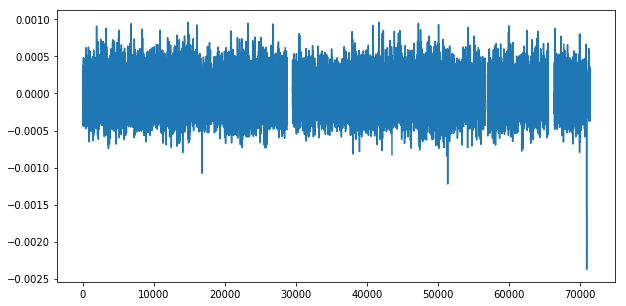

In [5]:
plt.figure(figsize=(10,5))
plt.plot(raw_list[44])
plt.show()

Cantidad de tramos:  842
Largo promedio entre tramos:  76.4809976247031
Largo mediana entre tramos:  74.0
Largo min entre tramos:  1
Largo max entre tramos:  149
Log-likehood con 15  estados del conjunto de entrenamiento 71277.51864178831


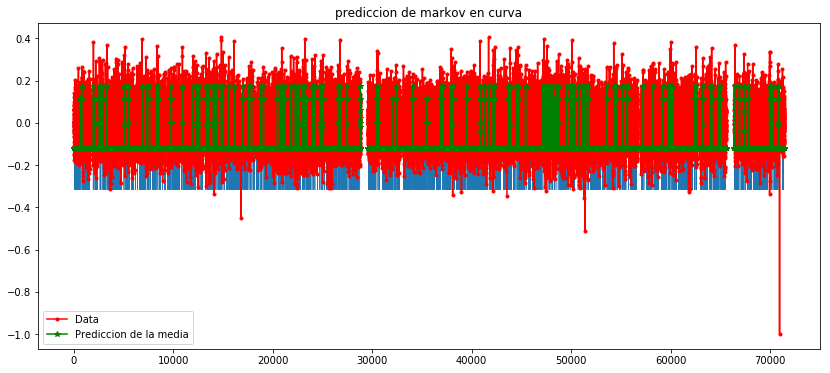

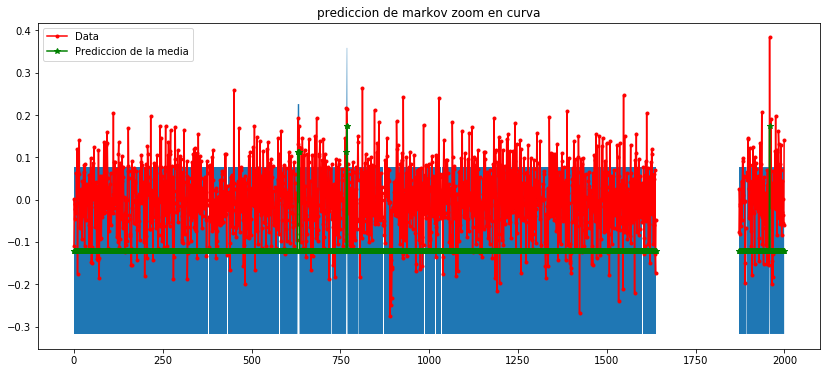

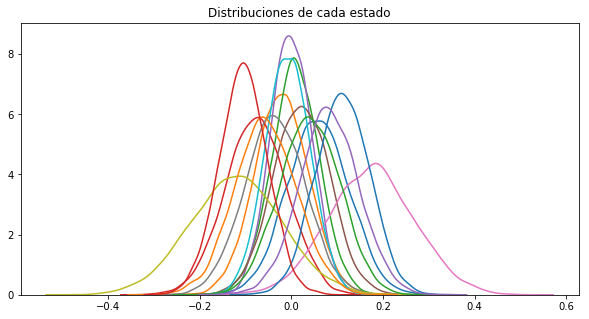

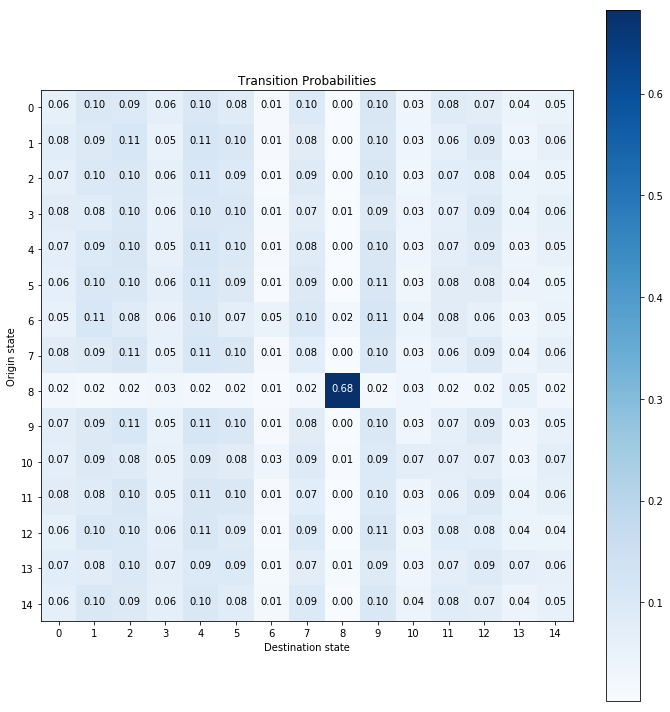

Log-likehood con 15  estados del conjunto de entrenamiento 71277.51864178831


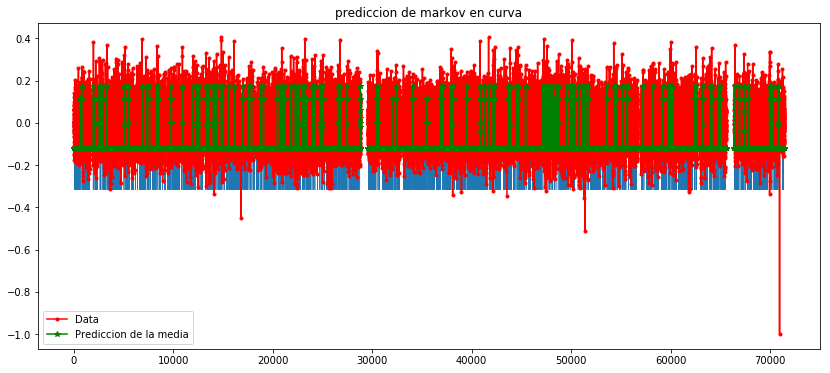

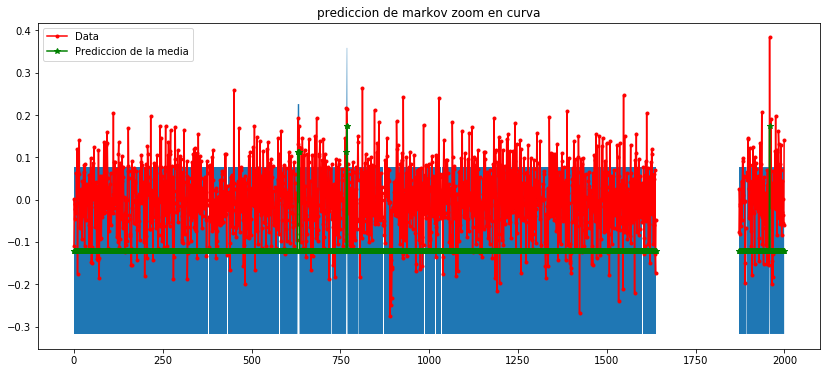

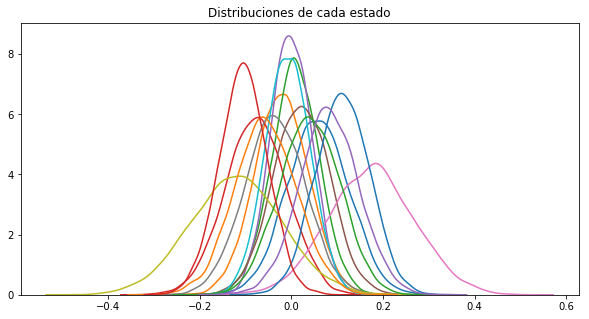

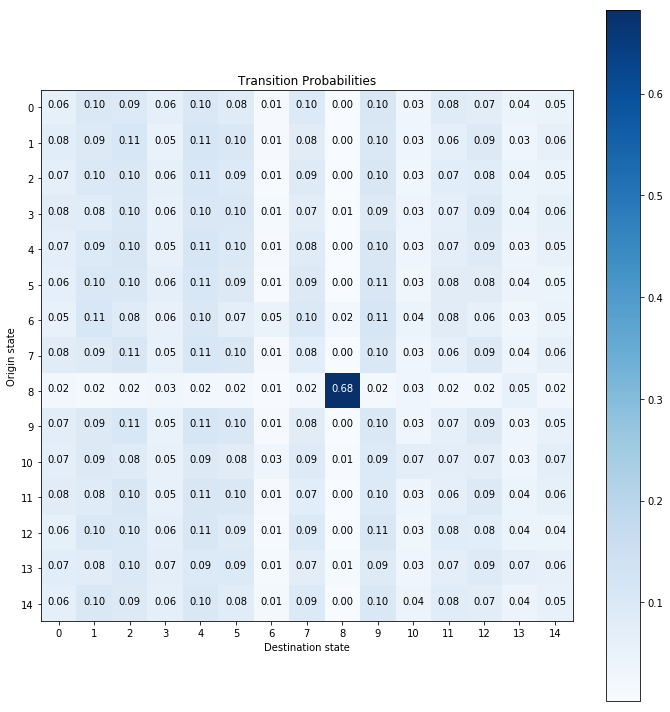

Log-likehood con 15  estados del conjunto de entrenamiento 71277.51864178831


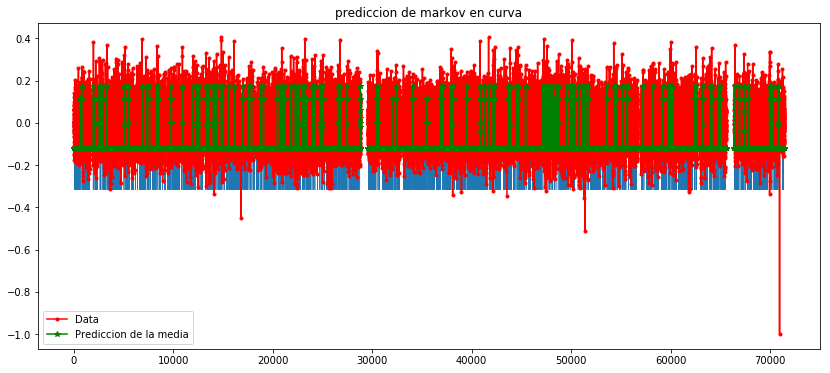

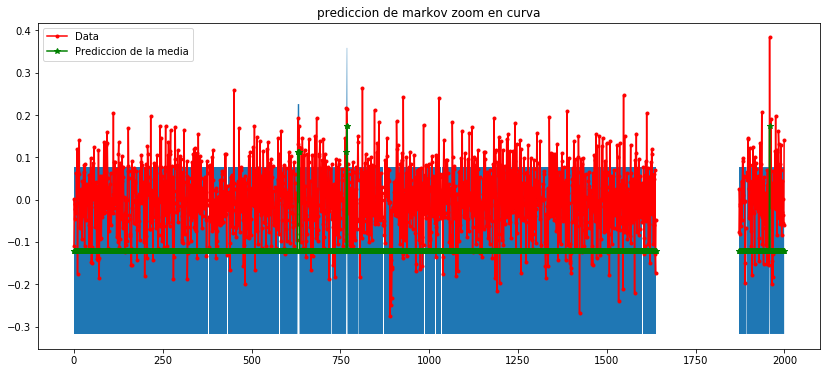

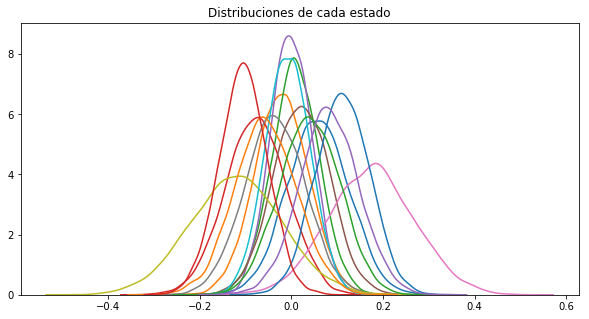

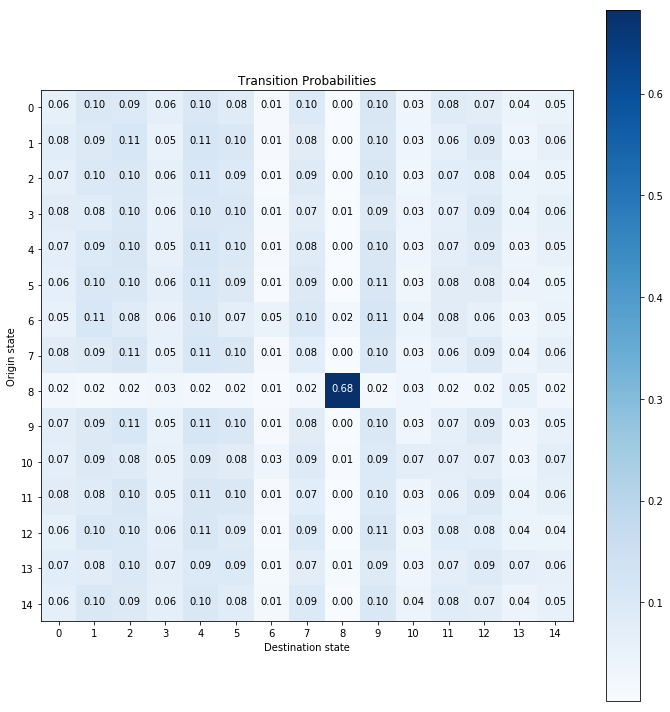

Log-likehood con 15  estados del conjunto de entrenamiento 71277.51864178831


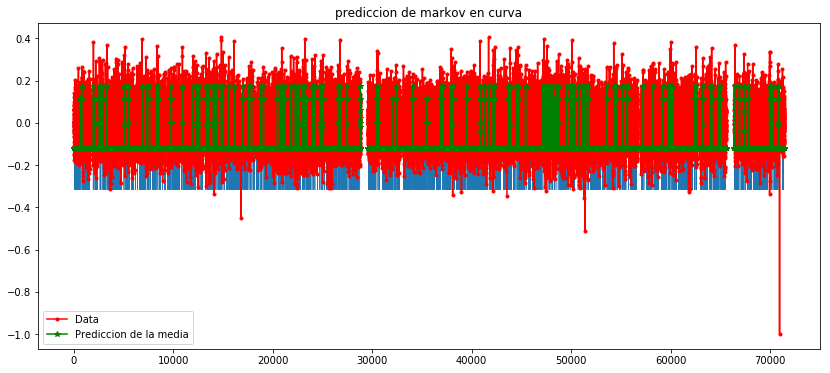

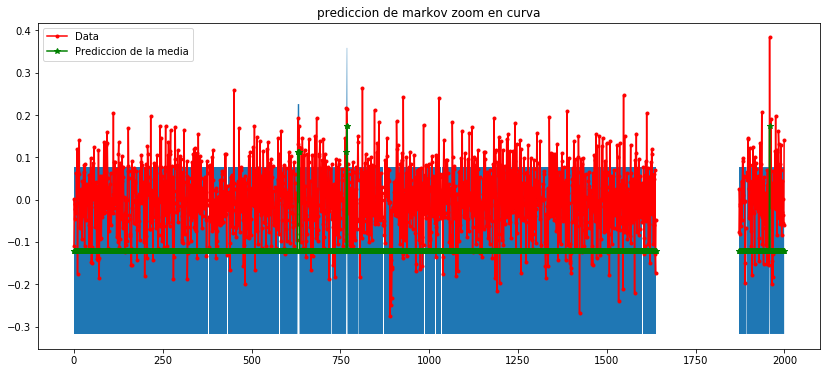

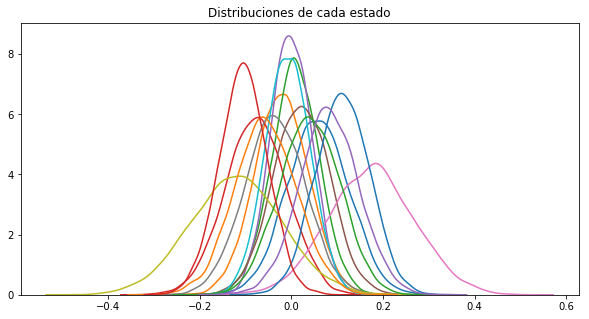

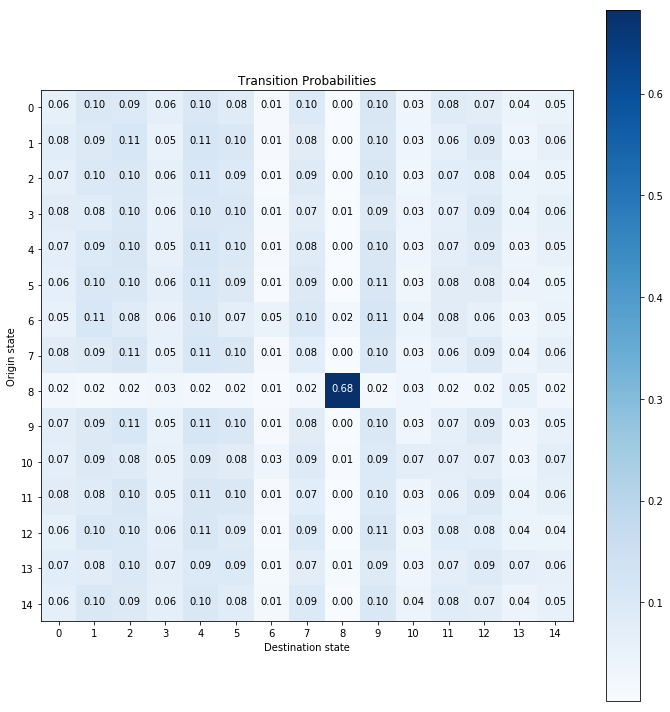

Log-likehood con 15  estados del conjunto de entrenamiento 71277.51864178831


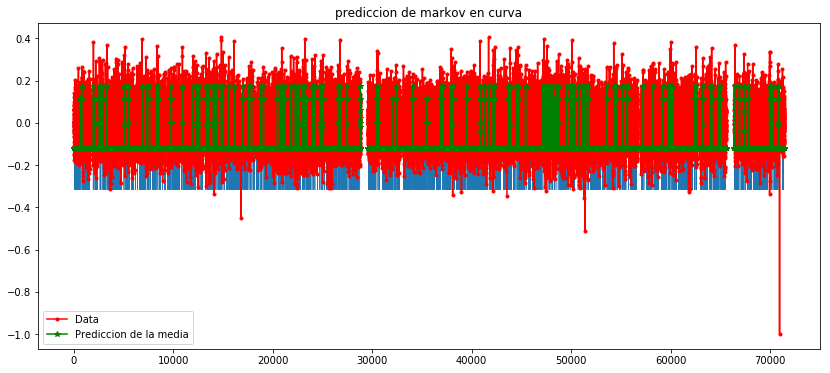

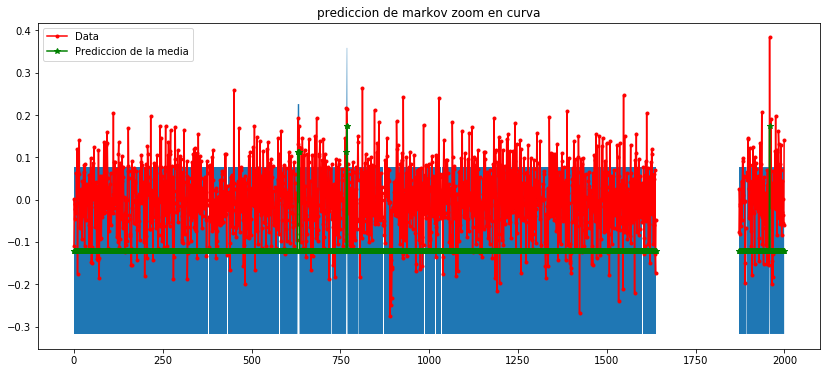

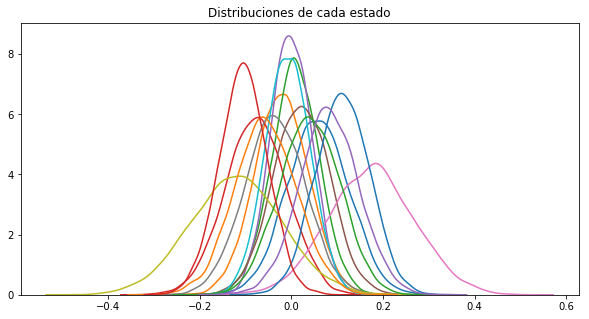

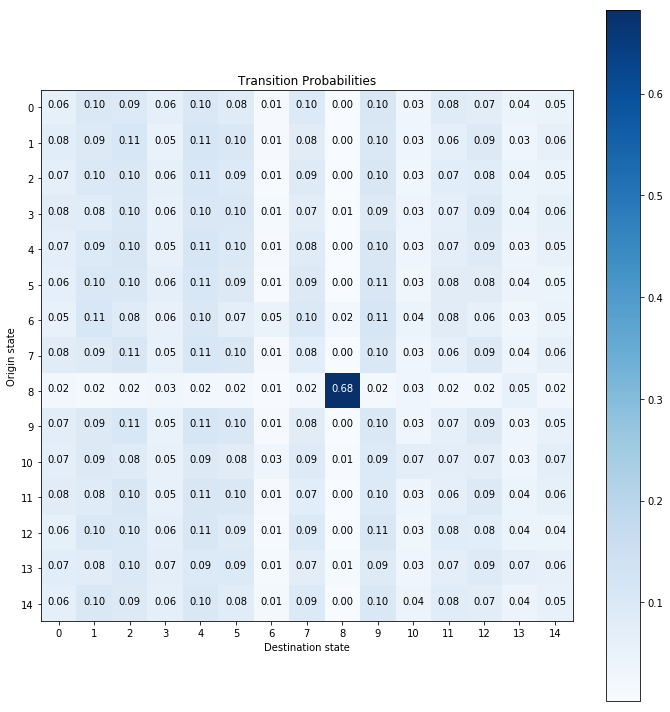

In [8]:
lc_our_detrend = raw_list[44]
lc_wind_nan = []
lengths = []
sublist = []
for value in lc_our_detrend:
    if np.isnan(value) and len(sublist) != 0:
        lc_wind_nan.append(np.asarray(sublist))
        lengths.append(len(sublist))
        sublist = []
    elif np.isnan(value) and len(sublist) == 0:
        continue
    else: 
        sublist.append(value) 
if len(sublist) != 0:      ####IMOPRTANTEEEEEEEEEEEEEEEEEEEEEEEEEE
    lc_wind_nan.append(np.asarray(sublist))
    lengths.append(len(sublist))
lc_wind_nan = np.asarray(lc_wind_nan)   
lengths = np.asarray(lengths)   

print("Cantidad de tramos: ",len(lengths))
print("Largo promedio entre tramos: ", np.mean(lengths))
print("Largo mediana entre tramos: ", np.median(lengths))
print("Largo min entre tramos: ", np.min(lengths))
print("Largo max entre tramos: ", np.max(lengths))

lc_wind_nan = np.concatenate(lc_wind_nan).reshape(-1,1)
lc_wind_nan = lc_wind_nan/np.abs(np.min(lc_wind_nan)) 

for i in range(5):
    n_sta = 15
    np.random.seed(44)
    markov_model = hmm.GaussianHMM(n_components=n_sta, n_iter=50)
    markov_model.fit(lc_wind_nan , lengths)

    print("Log-likehood con",n_sta," estados del conjunto de entrenamiento",markov_model.score(lc_wind_nan)) 

    plot_model_and_data(lc_wind_nan, markov_model, p_n=2000, real_lc= lc_our_detrend) 

    plt.figure(figsize=(10,5))
    for i in range(n_sta):
        r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
        sns.distplot(r,kde=True, hist=False)

    plt.title("Distribuciones de cada estado")
    plt.show()
    plot_state_matrix(markov_model.transmat_,np.arange(n_sta))
    plt.show()

Cantidad de tramos:  842
Largo promedio entre tramos:  76.4809976247031
Largo mediana entre tramos:  74.0
Largo min entre tramos:  1
Largo max entre tramos:  149
Log-likehood con 5  estados del conjunto de entrenamiento 71087.04574699623


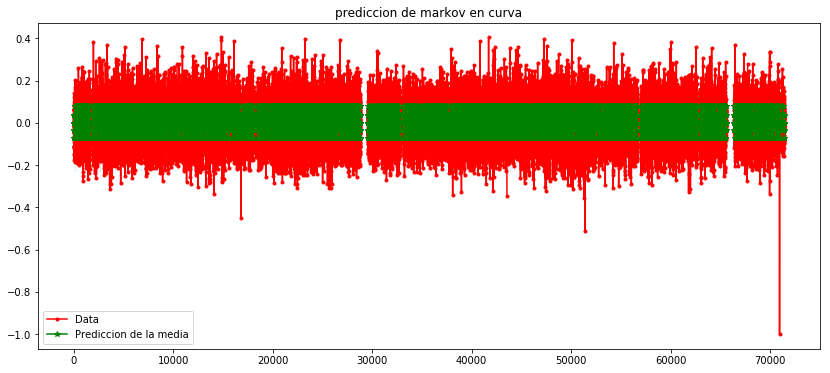

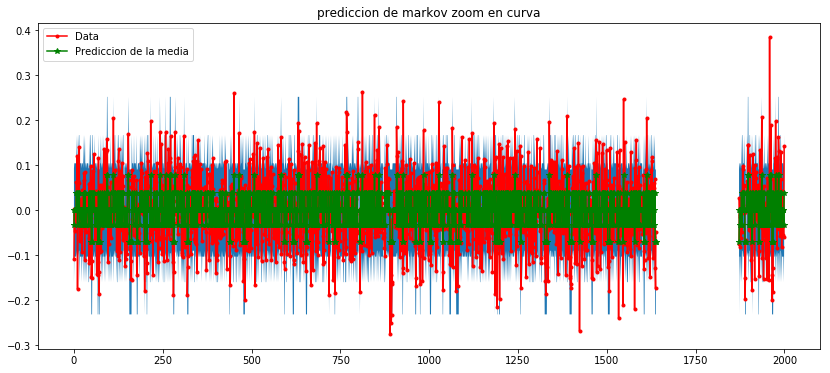

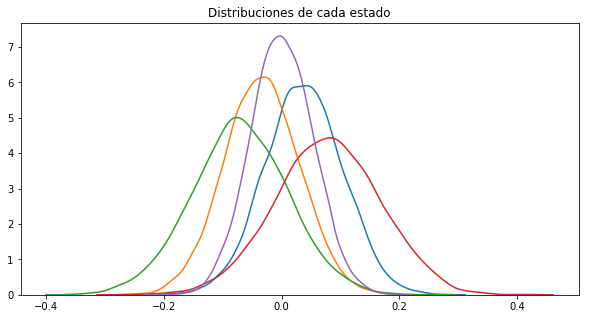

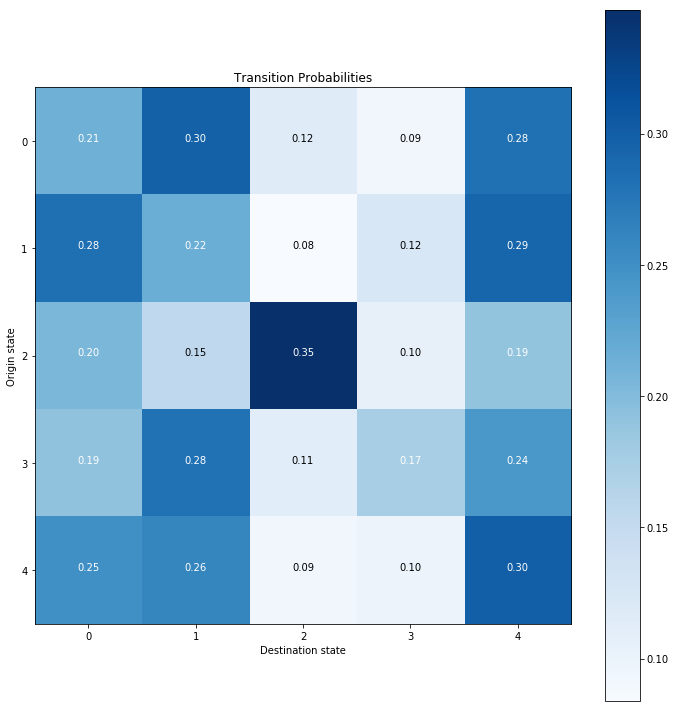

Log-likehood con 6  estados del conjunto de entrenamiento 71111.49472808858


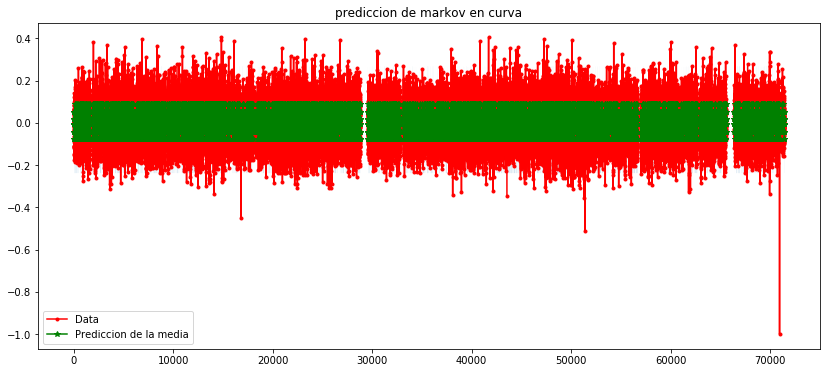

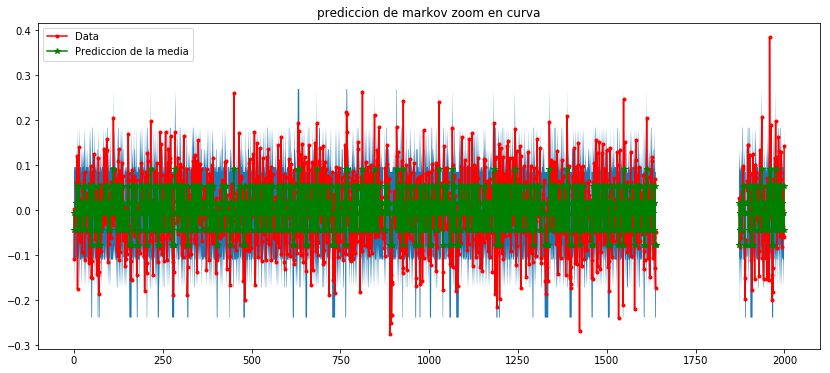

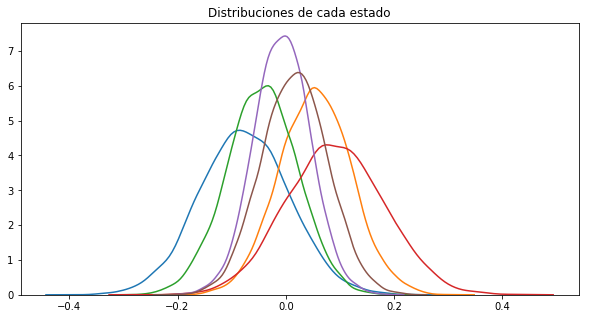

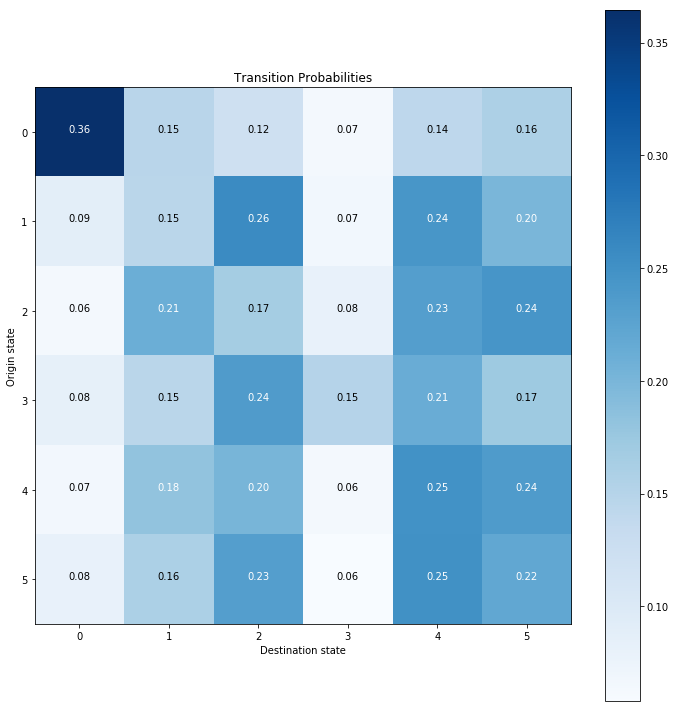

Log-likehood con 7  estados del conjunto de entrenamiento 71174.54438584513


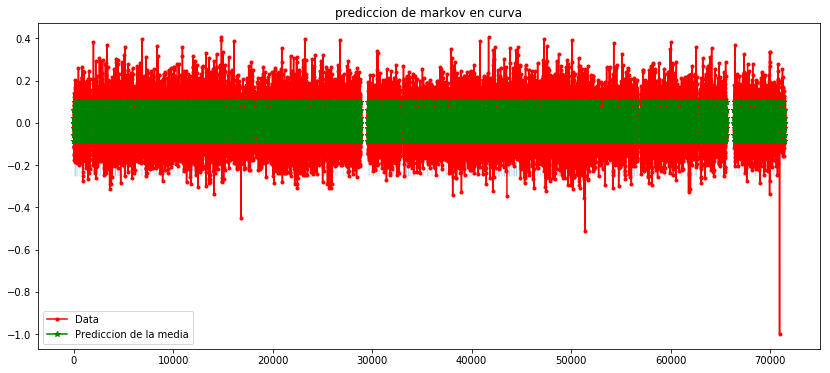

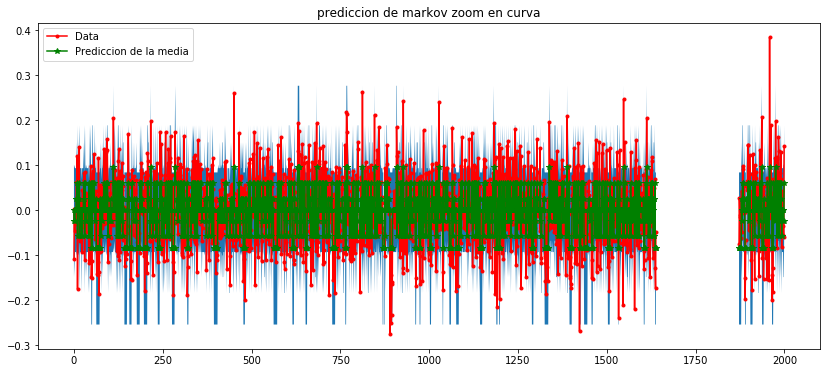

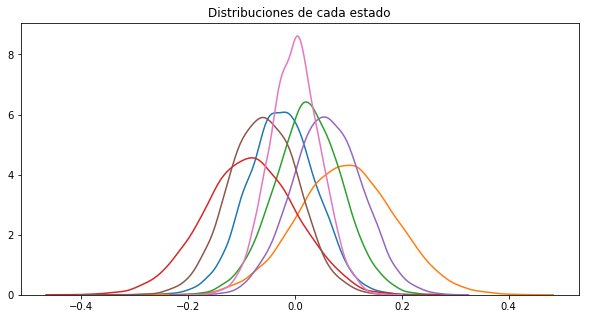

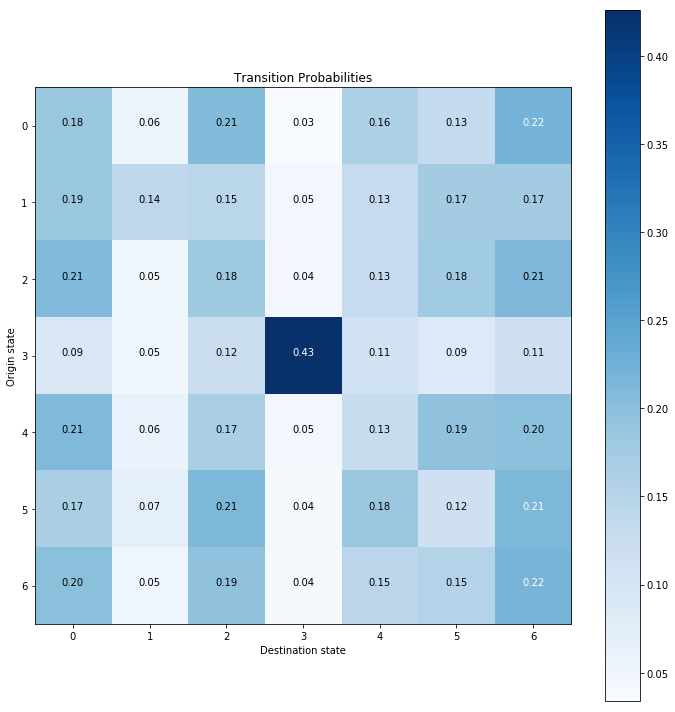

Log-likehood con 8  estados del conjunto de entrenamiento 71190.53424704057


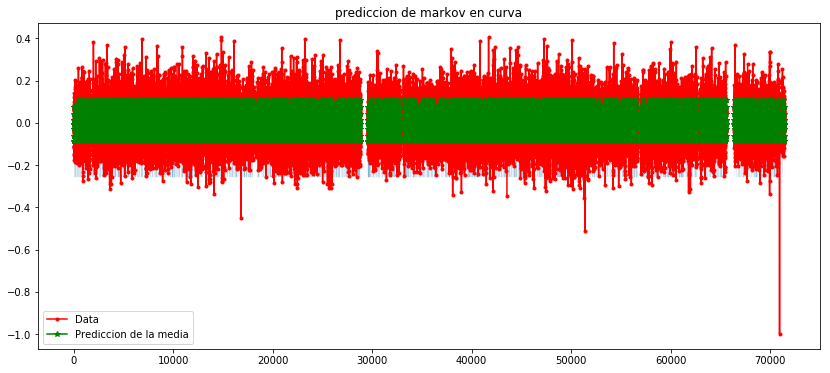

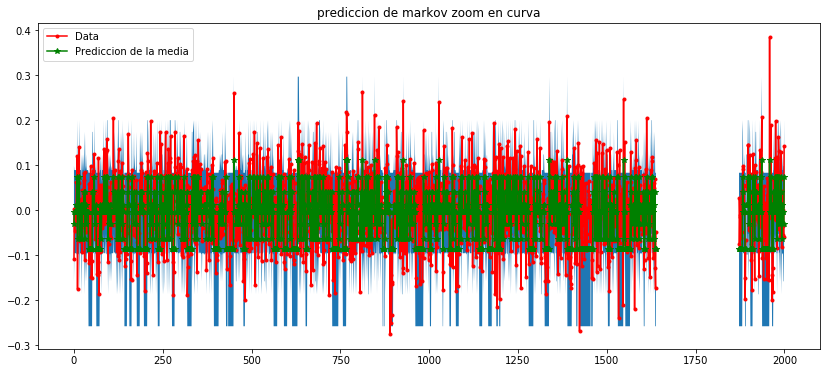

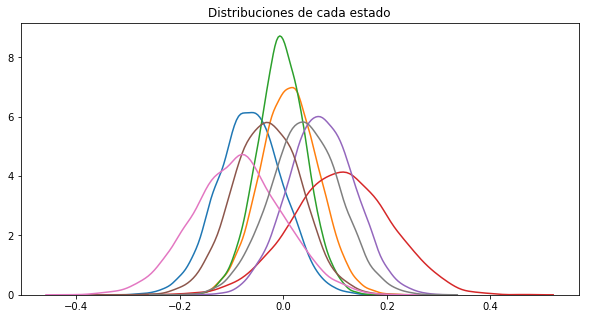

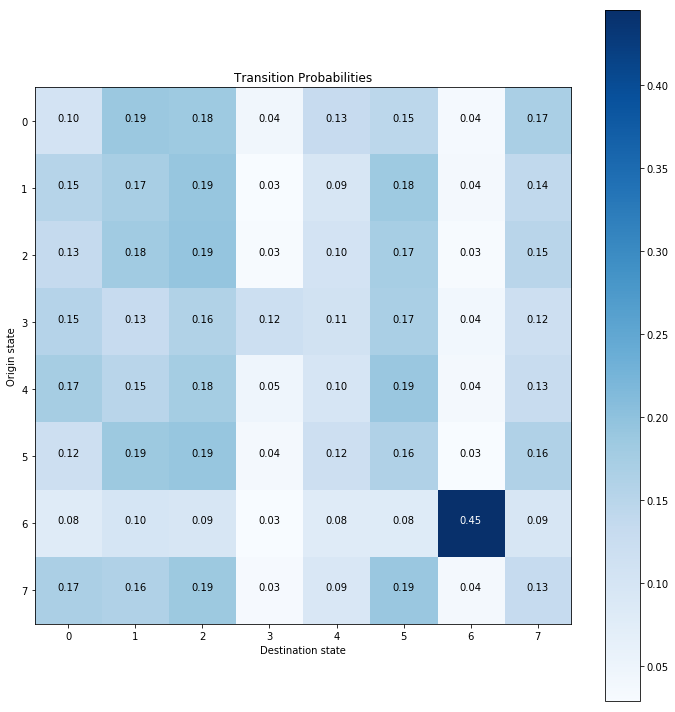

Log-likehood con 9  estados del conjunto de entrenamiento 71234.78424073484


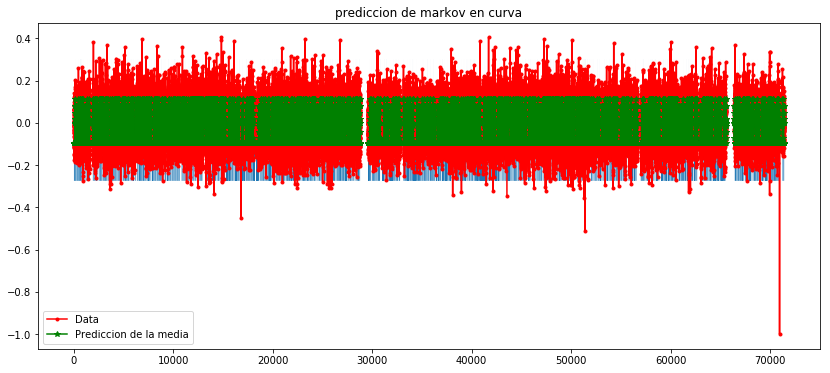

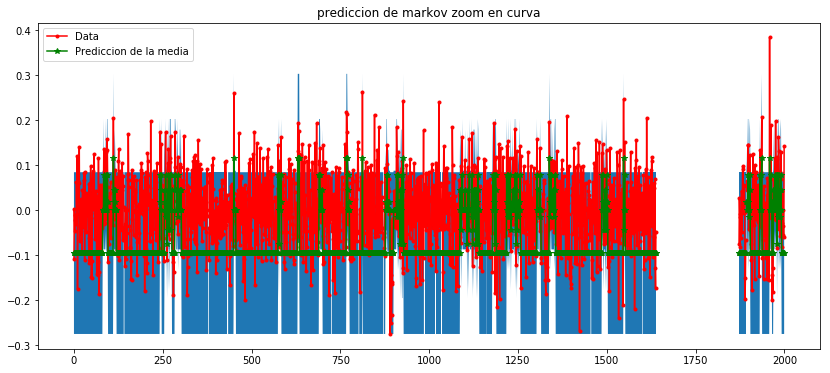

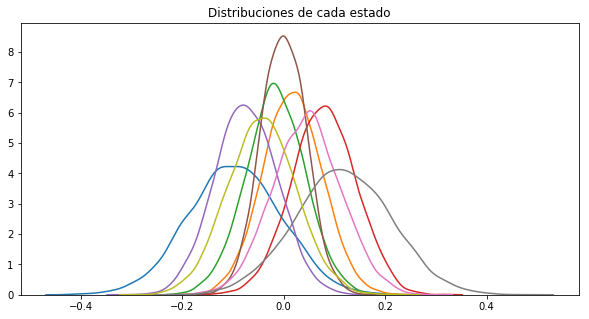

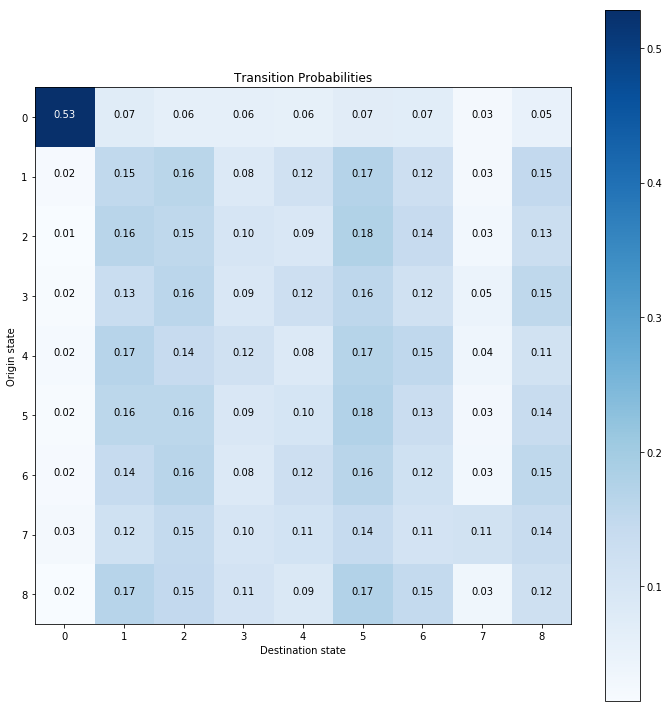

Log-likehood con 10  estados del conjunto de entrenamiento 71242.52093066018


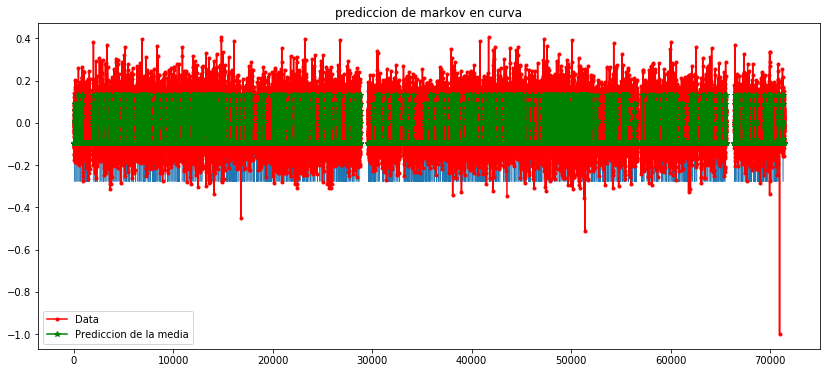

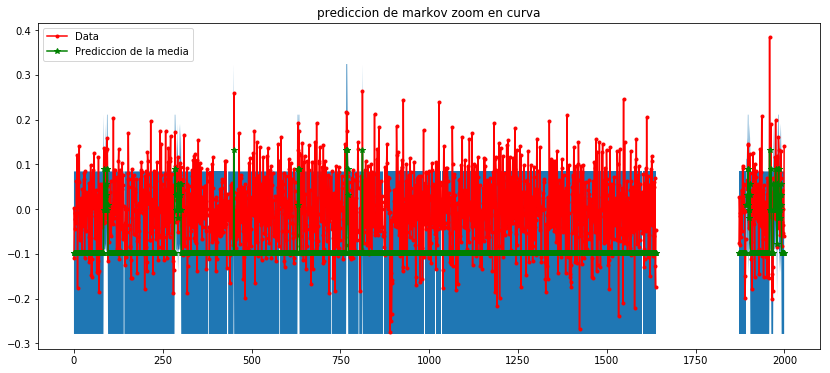

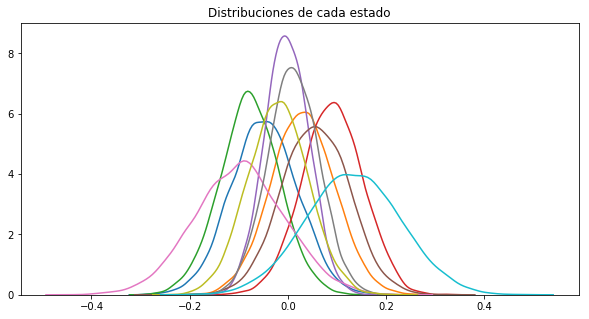

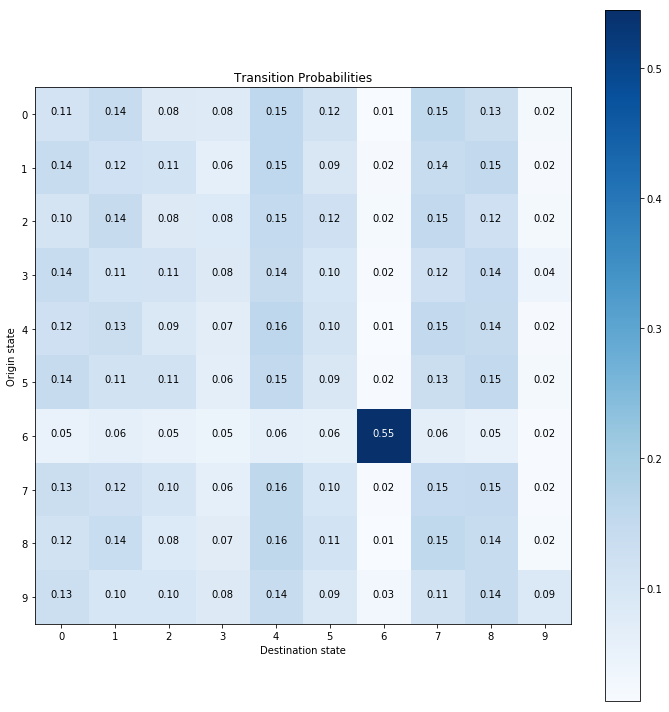

Log-likehood con 11  estados del conjunto de entrenamiento 71264.99938390274


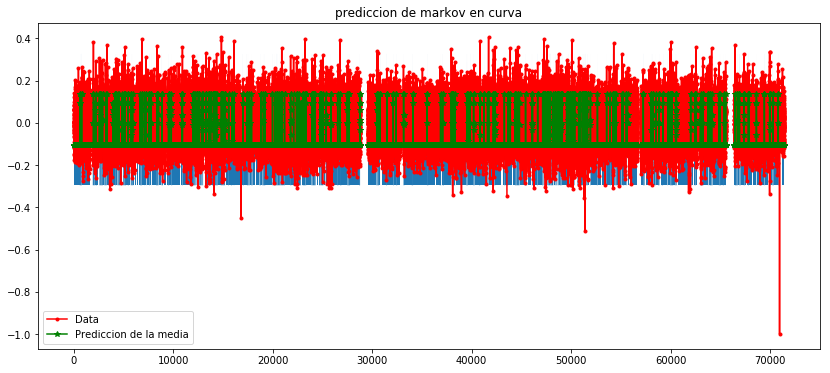

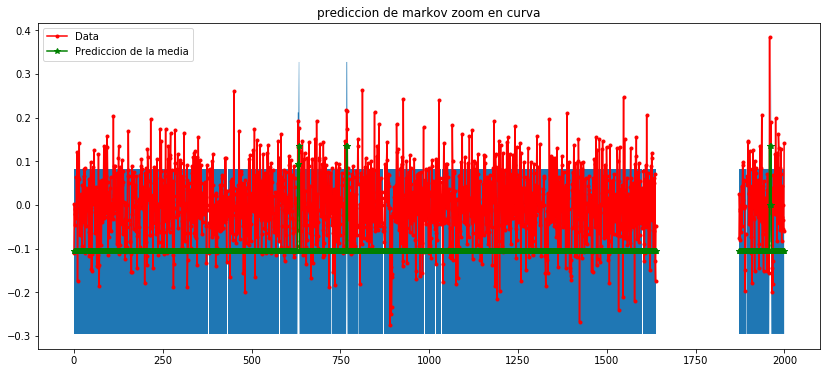

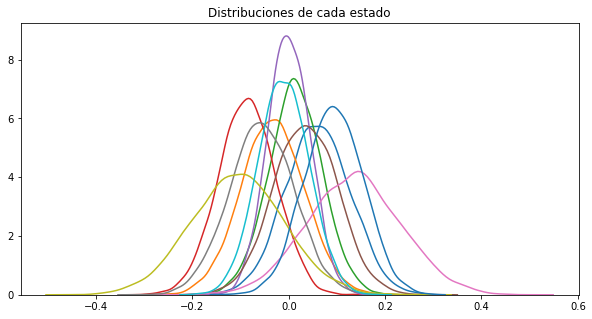

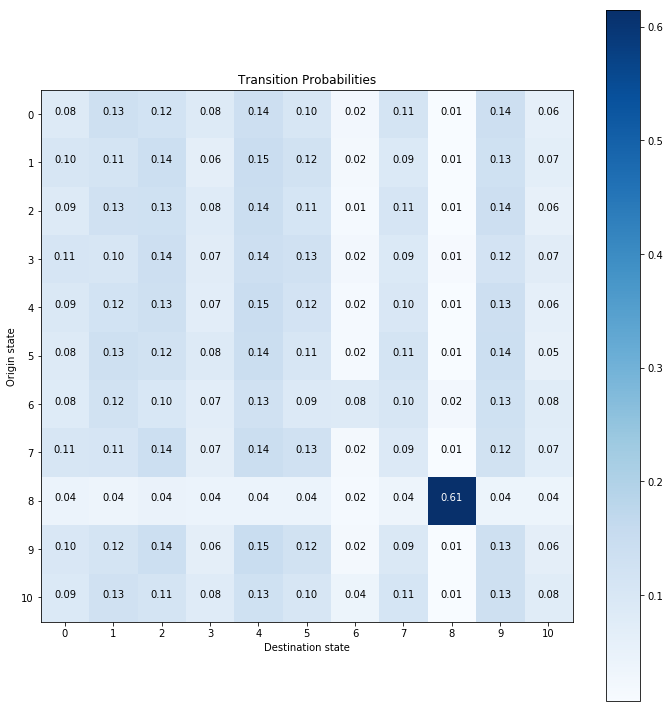

Log-likehood con 12  estados del conjunto de entrenamiento 71264.03432823074


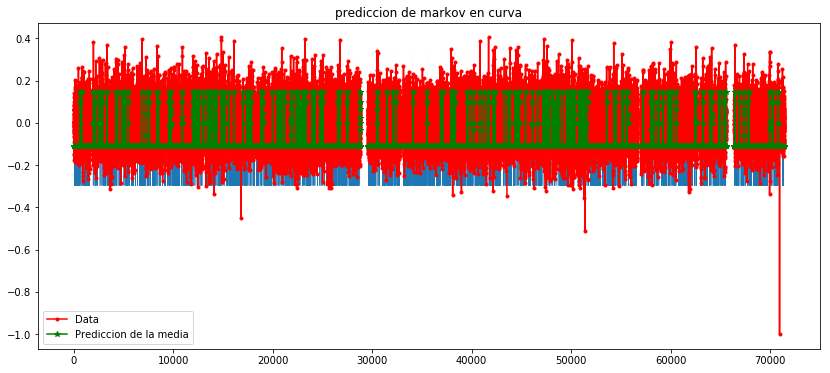

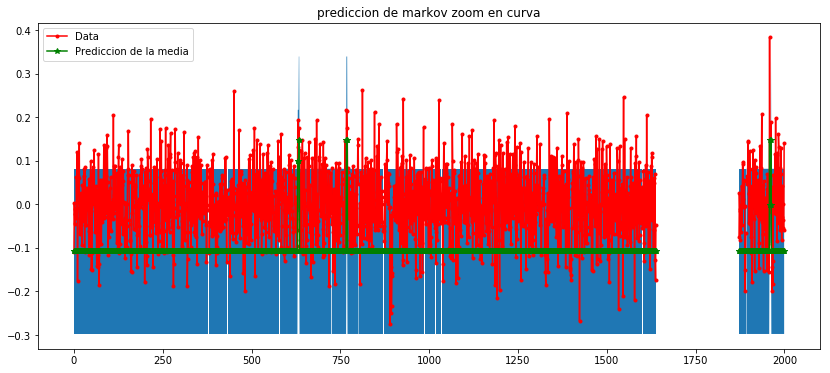

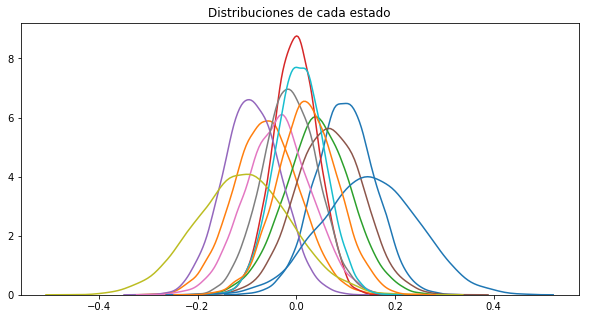

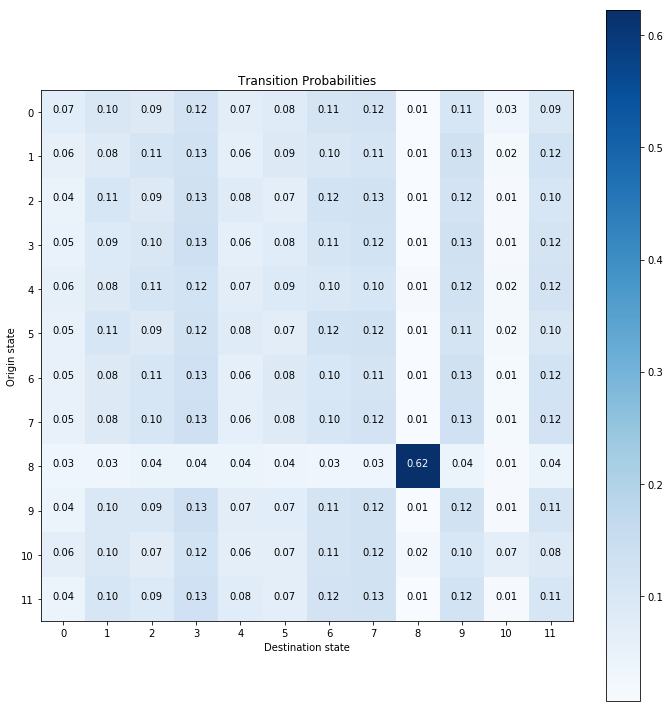

Log-likehood con 13  estados del conjunto de entrenamiento 71274.3333691315


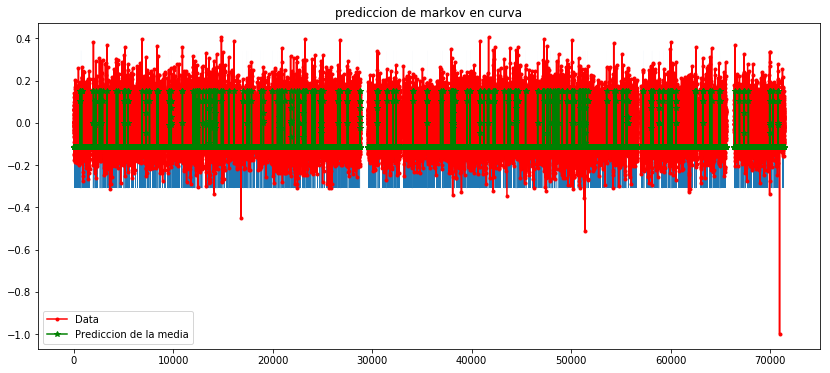

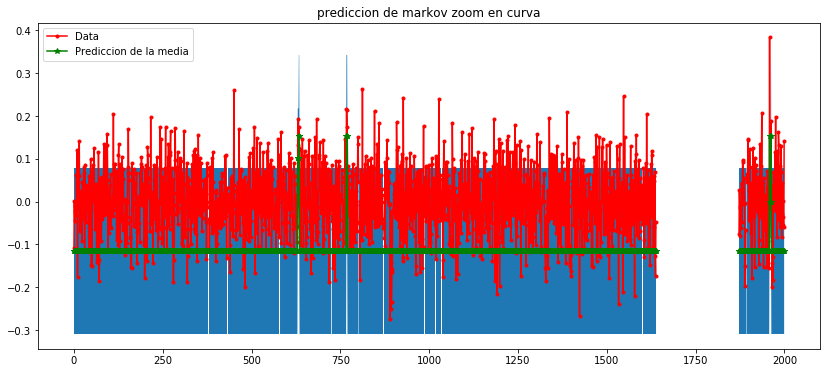

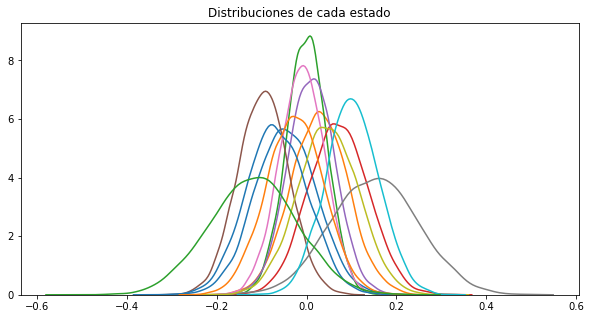

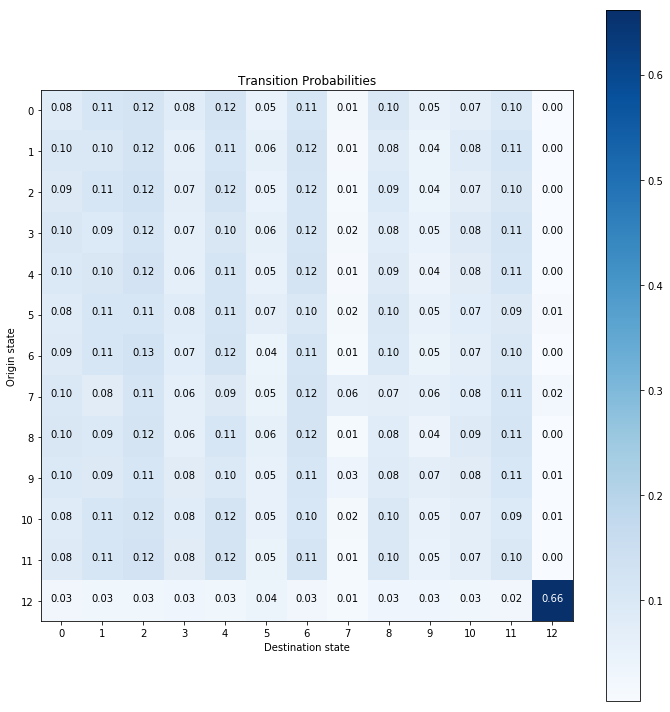

Log-likehood con 14  estados del conjunto de entrenamiento 71273.85619409764


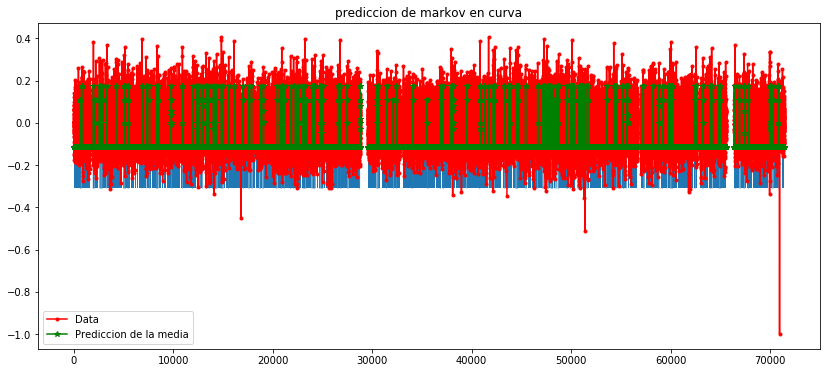

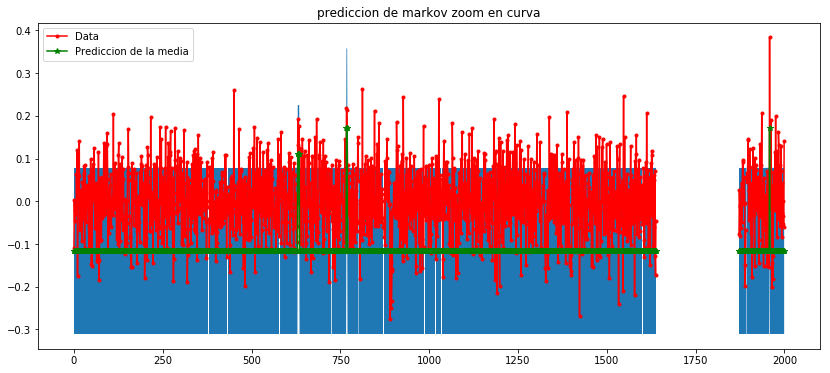

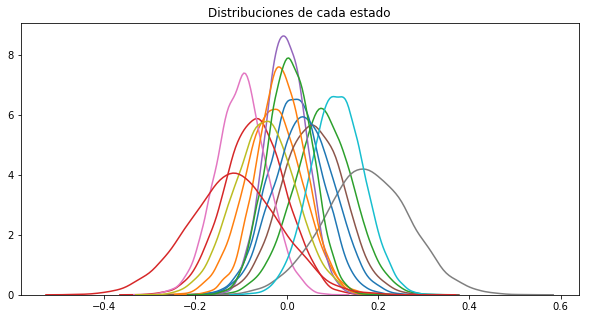

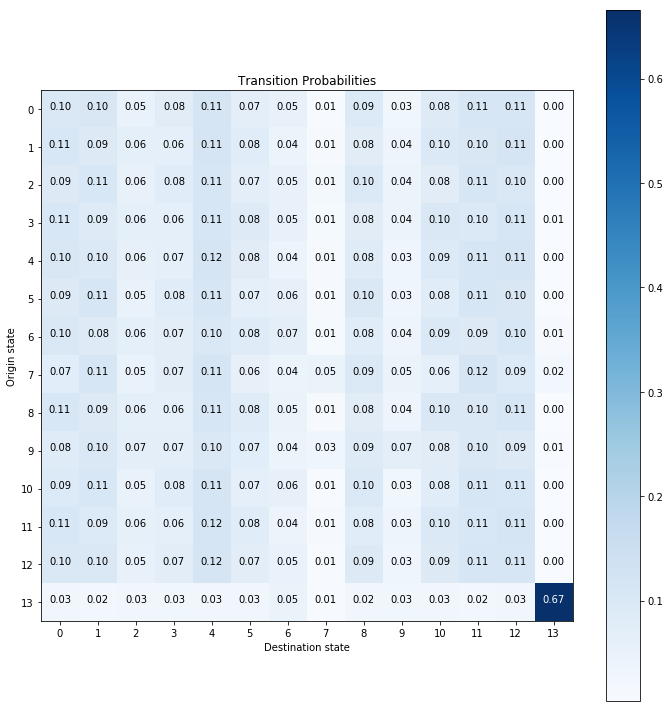

Log-likehood con 15  estados del conjunto de entrenamiento 71277.51864178831


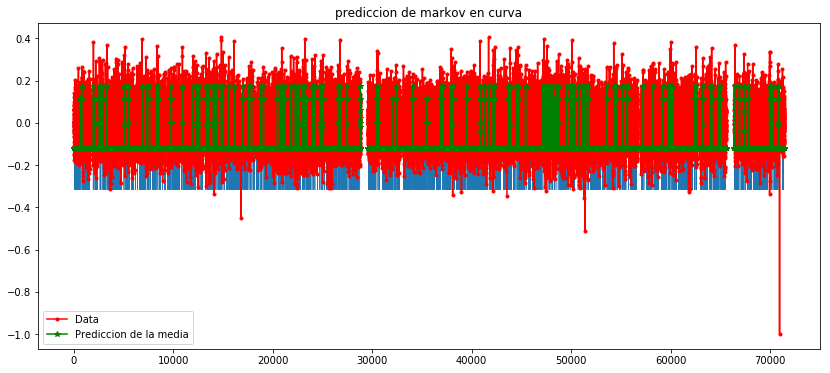

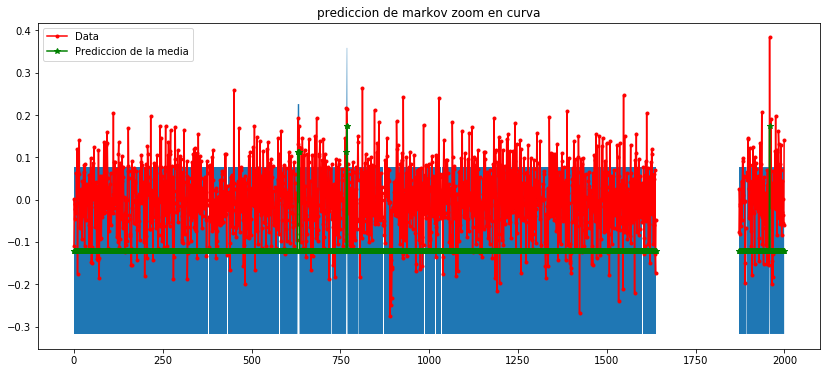

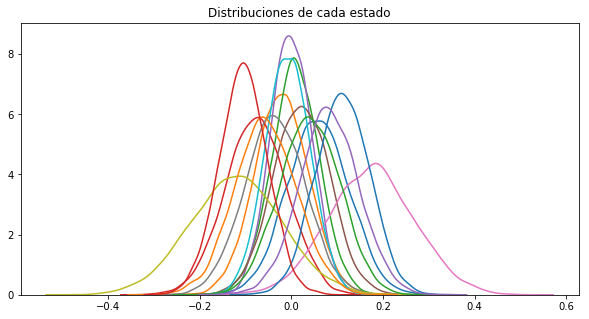

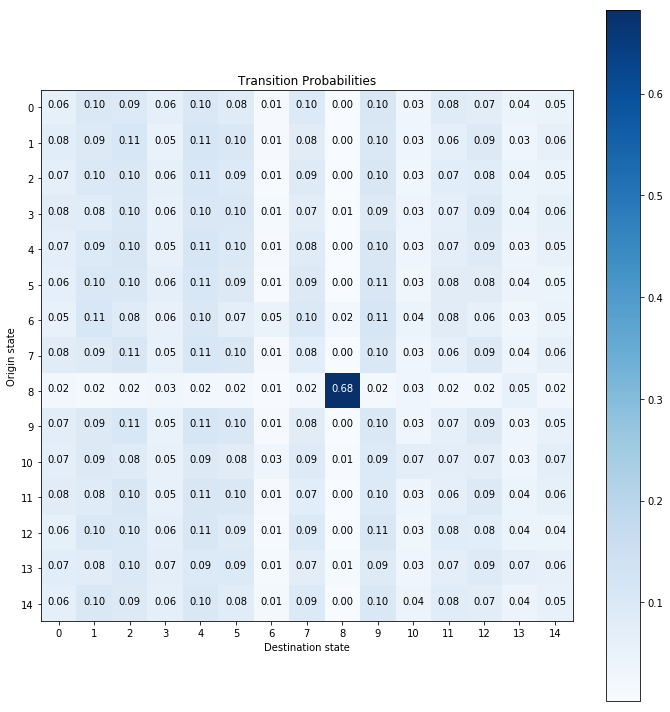

In [9]:
lc_our_detrend = raw_list[44]
lc_wind_nan = []
lengths = []
sublist = []
for value in lc_our_detrend:
    if np.isnan(value) and len(sublist) != 0:
        lc_wind_nan.append(np.asarray(sublist))
        lengths.append(len(sublist))
        sublist = []
    elif np.isnan(value) and len(sublist) == 0:
        continue
    else: 
        sublist.append(value) 
if len(sublist) != 0:      ####IMOPRTANTEEEEEEEEEEEEEEEEEEEEEEEEEE
    lc_wind_nan.append(np.asarray(sublist))
    lengths.append(len(sublist))
lc_wind_nan = np.asarray(lc_wind_nan)   
lengths = np.asarray(lengths)   

print("Cantidad de tramos: ",len(lengths))
print("Largo promedio entre tramos: ", np.mean(lengths))
print("Largo mediana entre tramos: ", np.median(lengths))
print("Largo min entre tramos: ", np.min(lengths))
print("Largo max entre tramos: ", np.max(lengths))

lc_wind_nan = np.concatenate(lc_wind_nan).reshape(-1,1)
lc_wind_nan = lc_wind_nan/np.abs(np.min(lc_wind_nan)) 

for n_sta in [5,6,7,8,9,10,11,12,13,14,15]:
    np.random.seed(44)
    markov_model = hmm.GaussianHMM(n_components=n_sta, n_iter=50)
    markov_model.fit(lc_wind_nan , lengths)

    print("Log-likehood con",n_sta," estados del conjunto de entrenamiento",markov_model.score(lc_wind_nan)) 

    plot_model_and_data(lc_wind_nan, markov_model, p_n=2000, real_lc= lc_our_detrend) 

    plt.figure(figsize=(10,5))
    for i in range(n_sta):
        r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
        sns.distplot(r,kde=True, hist=False)

    plt.title("Distribuciones de cada estado")
    plt.show()
    plot_state_matrix(markov_model.transmat_,np.arange(n_sta))
    plt.show()

In [ ]:
lc_our_detrend = 
lc_wind_nan = []
lengths = []
sublist = []
for value in lc_our_detrend:
    if np.isnan(value) and len(sublist) != 0:
        lc_wind_nan.append(np.asarray(sublist))
        lengths.append(len(sublist))
        sublist = []
    elif np.isnan(value) and len(sublist) == 0:
        continue
    else: 
        sublist.append(value) 
if len(sublist) != 0:      ####IMOPRTANTEEEEEEEEEEEEEEEEEEEEEEEEEE
    lc_wind_nan.append(np.asarray(sublist))
    lengths.append(len(sublist))
lc_wind_nan = np.asarray(lc_wind_nan)   
lengths = np.asarray(lengths)   

print("Cantidad de tramos: ",len(lengths))
print("Largo promedio entre tramos: ", np.mean(lengths))
print("Largo mediana entre tramos: ", np.median(lengths))
print("Largo min entre tramos: ", np.min(lengths))
print("Largo max entre tramos: ", np.max(lengths))

lc_wind_nan = np.concatenate(lc_wind_nan).reshape(-1,1)
lc_wind_nan = lc_wind_nan/np.abs(np.min(lc_wind_nan)) 

n_sta=15
markov_model = hmm.GaussianHMM(n_components=n_sta, n_iter=50)
markov_model.fit(lc_wind_nan , lengths)

print("Log-likehood con",n_sta," estados del conjunto de entrenamiento",markov_model.score(lc_wind_nan)) 

plot_model_and_data(lc_wind_nan, markov_model, p_n=2000, real_lc= lc_our_detrend) 

plt.figure(figsize=(10,5))
for i in range(n_sta):
    r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
    sns.distplot(r,kde=True, hist=False)

plt.title("Distribuciones de cada estado")
plt.show()
plot_state_matrix(markov_model.transmat_,np.arange(n_sta))
plt.show()

In [ ]:
n_state = [5,10,15,25,35]
for n_sta in n_state:
    markov_model = hmm.GaussianHMM(n_components=n_sta, n_iter=50)
    markov_model.fit(new_lc)
    print("Log-likehood con",n_sta," estados del conjunto de entrenamiento",markov_model.score(new_lc)) 
    
    X_state = markov_model.predict(new_lc) #predice el estado, no el valor 
    plt.figure(figsize=(14,5))
    plt.plot(new_lc,'r.-',label="Data") #-- here put train or val plt.legend() plt.show()
    plt.fill_between(np.arange(np.asarray(new_lc).shape[0]),
                     markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0],
                     markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0]) 
    plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media") 
    plt.legend()
    plt.title("prediccion de markov en toda curva")
    plt.show()
    
    plt.figure(figsize=(14,5))
    plt.plot(new_lc[:2000],'r.-',label="Data") #-- here put train or val plt.legend() plt.show()
    plt.fill_between(np.arange(2000),
                     markov_model.means_[X_state[:2000]][:,0]-1.96*np.sqrt(markov_model.covars_[X_state[:2000]])[:,0,0],
                     markov_model.means_[X_state[:2000]][:,0]+1.96*np.sqrt(markov_model.covars_[X_state[:2000]])[:,0,0]) 
    plt.plot(markov_model.means_[X_state[:2000]][:,0],'g*-',label="Prediccion de la media") 
    plt.legend()
    plt.title("prediccion de markov en zoom de curva")
    plt.show()
    
    plt.figure(figsize=(10,5))
    for i in range(n_sta):
        r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
        sns.distplot(r,kde=True, hist=False)

    plt.title("Distribuciones de cada estado")
    plt.show()
    plot_state_matrix(markov_model.transmat_,np.arange(n_sta))
    plt.show()